Authoren:
Fabiab Franke (Dsai105347),
Vincent Vogt (Dsai105181),
Gruppe 10

# Vorhersage des Mietpreises

Ziel des Projektes ist, ein Modell zu trainieren, welches den Mietpreis von Immobilien in Hamburg mit einer möglichst hohen Genauigkeit vorhersagen kann. Der Fokus liegt dabei auf Immobilien für die Private Nutzung.



1.  Vorgehensweise  
2.  Marktübersicht
3.  Datenbeschaffung
4.  Datenaufbereitung
5.  Explorative Datenanalyse
6.  Modellierung
7.  Evaluierung
8.  Fazit


## 1. Vorgehensweise und Aufbau dieses Dokuments

Dieses Dokument ist in mehrere Kapitel unterteilt. Zu beginn eines jeden Kapitels werden alle benötigten Pakete für das jeweilige Kapitel importiert. Dadurch können im Verlauf des Dokumentes doppelungen entstehen. Dies wird aber in Kauf genommen, damit bei einem beliebigen Kapitel eingestiegen werden kann, ohne die Pakete der vorherhigen Kapitel laden zu müssen.

Des weiteren, werden in Regelmäßigen Abständen CSV-Datein erzeugt, welche als Speicherpunkte für das Projekt dienen. Dadurch können auch spätere Schritte ausgeführt werden ohne die vorherigen auszuführen.

Damit das Notebook ohne Komplikationen ausgeführt werden kann, sollten die CSV-Datein im gleichen Verzeichnis liegen, in welchem auch das Notebook ausgeführt wird. Wenn die Datein sich in einem freigegebenen Ordner con Google befinden, empfiehlt es sich eine Kopie herunterzuladen. Denn dann kann aus Colab nicht auf die Daten zugegriffen werden. Eine Alternative ist es die Daten im eigenen Google Ordner zu referenzieren.

Eine Verbindung zum eigenen Googledrive kann wie folgt hergestellt werden. 

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Zusätzlich muss der Pfad zum Ordner, indem das Notebook liegt, angepasst werden. Aufgrund der Share-Funktion von Google kommt es jedoch immer wieder zu Problemen. Am einfachsten ist es das Notebook mit den Daten einmal herunterzuladen und lokal in einem Jupyter Notebook zu öffnen. Wird dieser Weg gewählt muss ausgehend vom Jupyter Notebook der FolderPath entsprechend angepasst werden.

In [29]:
FolderPath = "/content/drive/MyDrive/ColabNotebooks/"

Inhaltlich Orientiert sich der Aufbau des Projektes am CRISP-DM. [(Quelle)](https://commons.wikimedia.org/wiki/File:CRISP-DM_Process_Diagram.png)

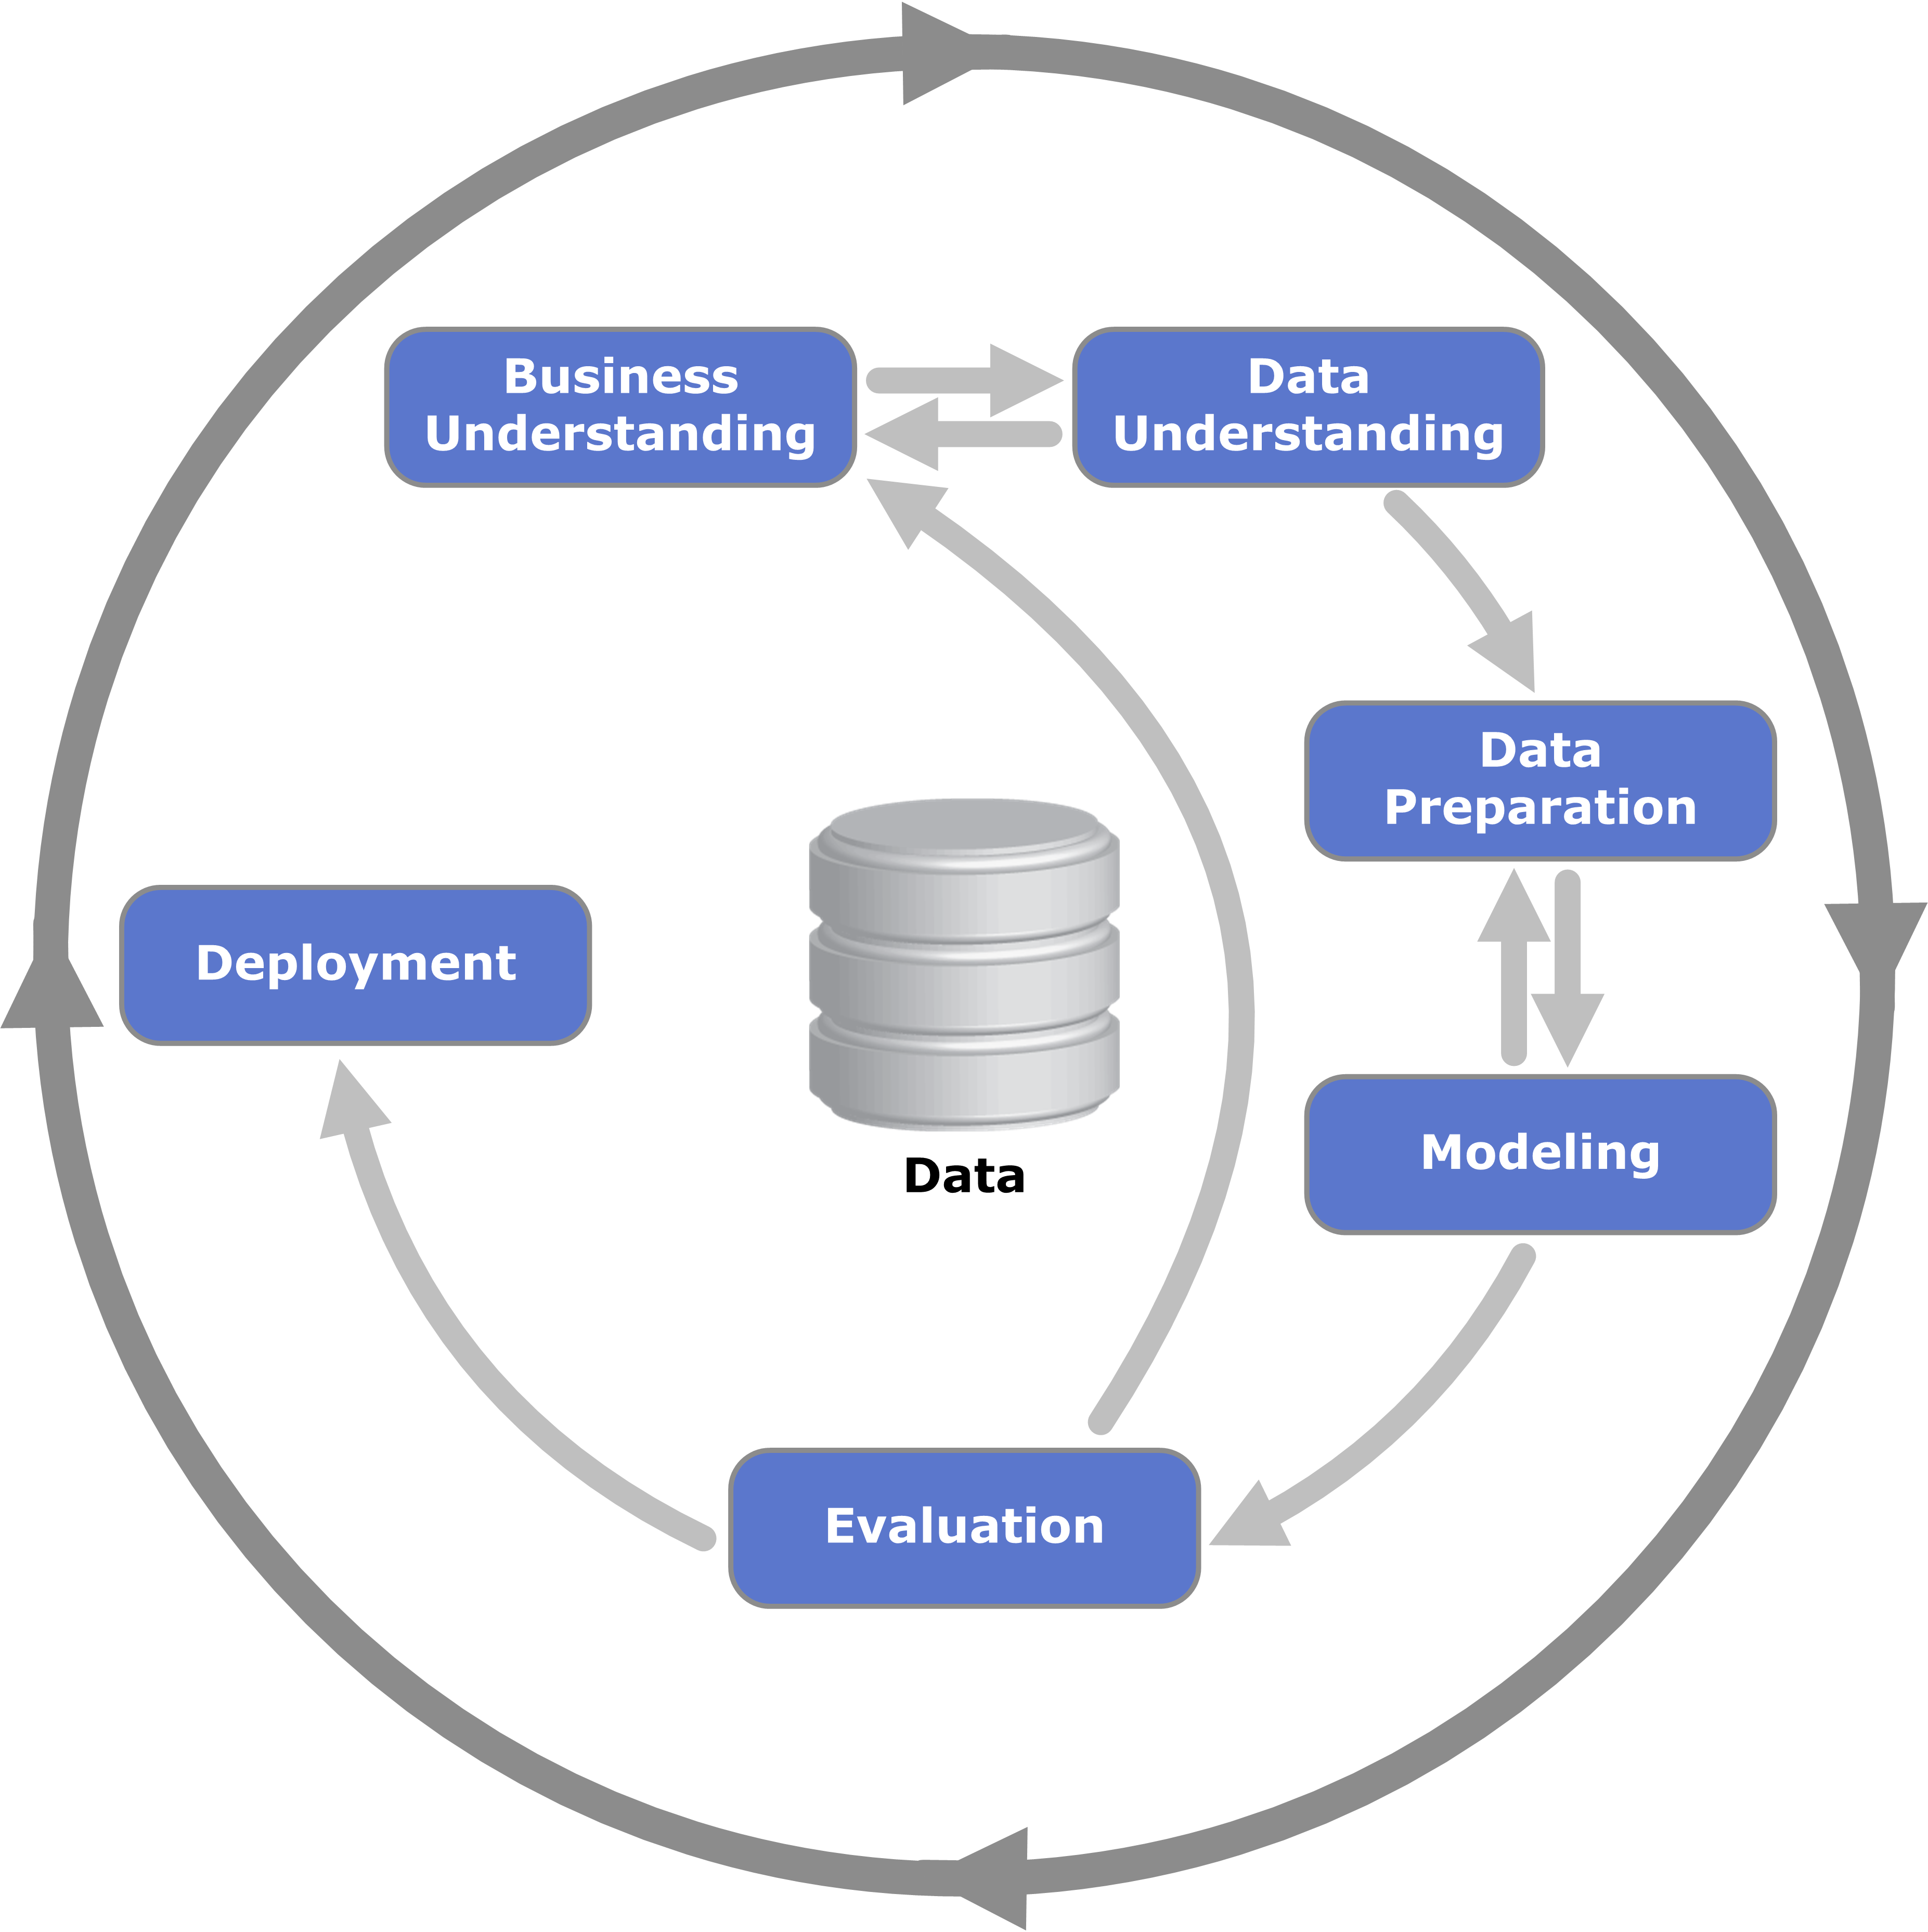

## 2. Marktübersicht

Die folgenden beiden Statistiken zeigen, dass die Mietpreise in Hamburg in der Vergangenheit kontinuirlich gestiegen sind.

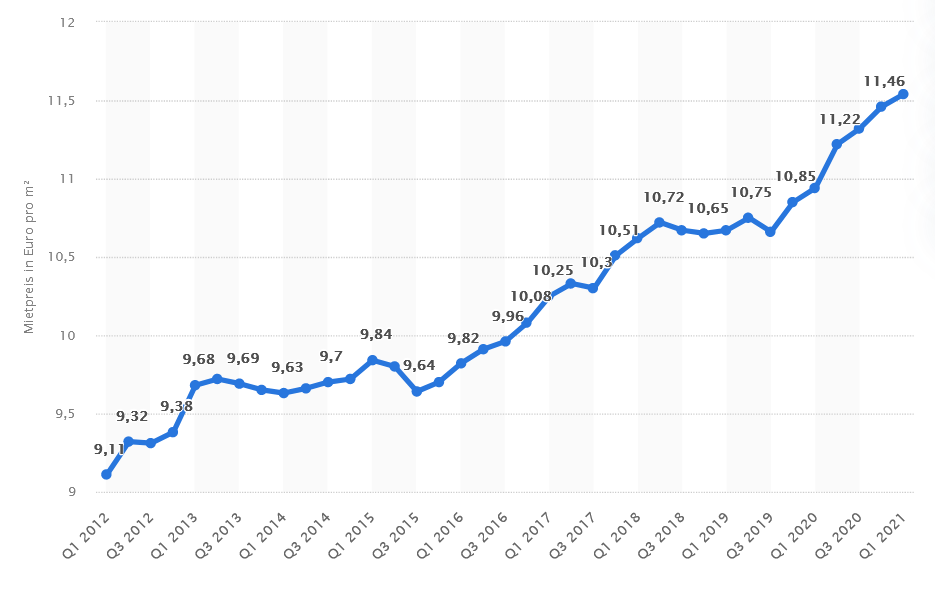

Quelle: [Mietpreisentwicklung](https://de.statista.com/statistik/daten/studie/971531/umfrage/mietpreise-auf-dem-wohnungsmarkt-in-hamburg/)

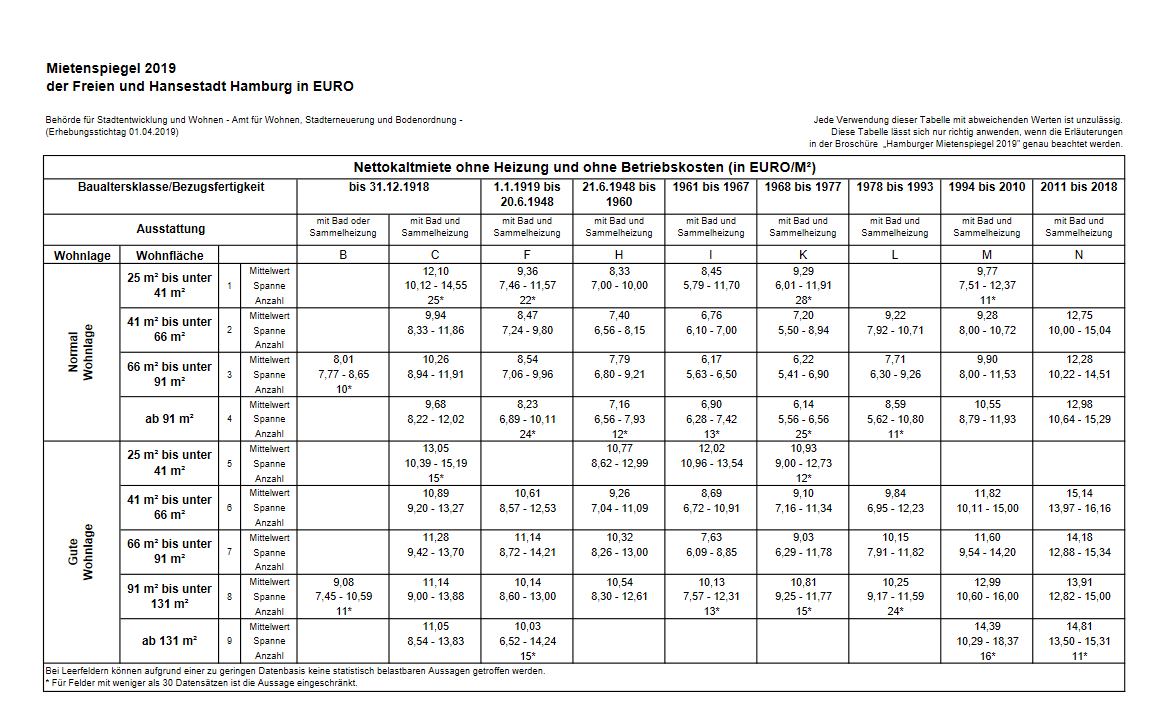

Quelle: [Mietenspiegel](https://www.hamburg.de/contentblob/13249498/8ce8401c8a829eb25d42b376c65693ff/data/d-mietenspiegel-tabelle-2019.pdf)

Da sich die Mietpreise stetig verändern, ist es für Mieter und Vermieter schwierig, eine angemessene Monatsmiete für eine Wohnung festzulegen. Aufgrund der eher seltenen Wechsel von Wohnungen, ist es besonders für private Mieter schwer bei den häufig wechselnden Mietpreisen auf dem laufenden zu bleiben. Dies gilt ebenfalls für Vermieter, welche eventuell nur ein Objekt vermieten. 

Um diesen beiden Personenkreisen zu helfen, soll in diesem Projekt ein Modell entwickelt werden, welches ihnen dabei hilft einen angemessenen Mietpreis für ein bestimmtes Objekt zu finden.

Es ist dabei wichtig möglichst viele relevante Features zu identifizieren. Die folgende Grafik zeigt z.B., dass der Mietpreis nicht nur von verschiedenen internen Faktoren, wie der Quadratmeteranzahl, abhängt, sondern auch anderen Faktoren, wie beispielsweise der Entfernung zum Stadtzentrum. Aus diesem Grund liegt bei deiesem Projekt ein besonderes Augenmerk im Feature Engineering darauf neue Features zu extrahieren.

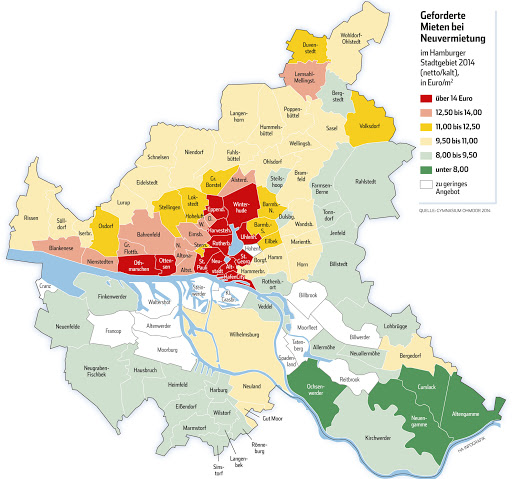

Quelle: [Mietpreiskarte](https://www.hamburgportal.de/immobilien/mietwohnungen/mietenspiegel/)

## 3. Datenbeschaffung

### 3.1 Crawlen der Immobielendaten

Bei unserer Recherche konnten wir kein fertiges Datenset zur Vorhersage von Mietpreisen in Hamburg ausfinding machen. Aus diesem Grund müssen die benötigten Daten aus dem Netz von einer Plattform gecrawlt werden. Dabei mussten unterschiedliche Hürden überwunden werden. 

Die verschiednenen Immobilienplattformen bieten für Hamburg je nach Plattform zwischen 1200 und 1400 Inserate. Leider verbieten einige Webseiten das Crawlen der Inhalte. Die übrigen Seiten lassen sich unterschiedlich leicht crawlen.

Ein erstes Problem stellte das dynamische Nachladen von Inhalten beim herunterscrollen einiger Webseiten dar.  Letztendlich fiel unsere Wahl auf die Seite "Immobilienscout24.de", welche 1264 Inserate enthält (Stand 01.05.2021).

Die ersten Test verliefen hier ohne Probleme. Nach kurzer Zeit stellte sich allerdings heraus, dass die Plattform sehr ausgereifte Techniken zum Erkennen und Blockieren von Crawlern hat.

In der ersten Iteration basierte der Crawler nur auf dem "responses" Package von Python. Diese Methode lieferte aber bereits nach einigen Seitenaufrufen pro Tag keine Ergebnisse mehr. Auch das Implementieren eines User Agents und angepasster Cookies konnte die Captcha Anfragen nicht umgehen. Aus diesem Grund wurde der Crawler nachträglich umgebaut und nutzt das Package "Selenium".

Zwar ist Selenium ressourcenintensiver als andere Lösungen, eignet sich aber hervoragend dafür auch komplexe Webseiten zu Crawlen. Hierfür wird Google Chrome oder Mozilla Firefox und der dazugehörige Webdriver benötigt. Weitere Informationen zu Selenium lassen sich auf der [offiziellen Webseite](https://www.selenium.dev/) nachlesen. Informationen zum Webdriver für Google Chrome finden sich außerdem [hier](https://sites.google.com/chromium.org/driver/). **Ohne einer Installation des Webdrivers auf dem eigenen PC lässt sich der folgende Code nicht ausführen**

Der nachfolgende Code crawlt alle immobilien der Webseite Immobilienscout24.de mit den Merkmalen:

| Feature | Beschreibung |
|---------|:--------------|
|ID| Eine eindeutige ID, welche dem Objekt zugeordnet werden kann. Diese ID wird von ImmoScout vergeben. Aus diesem Grund kann sie auch genutzt werden, um den Link so zu manipulieren, dass das Objekt direkt aufgerufen werden kann.|
|Titel|Überschrift des Inserates|
|Addresse|Die Addresse des Objektes. Manche Objekte geben nur die Postleitzahl und manche die komplette Addresse an.|
|Extras|Eine Liste, welche die Ausstattung der Wohnung beschreibt. Diese werden innerhalb des Inserates als Tags ausgegeben. Es scheint so, als gäbe es nur eine begrenze auswahl an Tags, welche von Immoscout vorgegeben sind und der Benutzer nur anklicken muss.|
|Add-Ons|Dies ist eine Liste, welche Versucht alle zusätzlichen Merkmale der Wohnung zu erfassen. Dies kann z.B. Größe der Wohnung, Heizungsart, Anzahl der Zimmer etc. sein. Ein großes Problem ist hier, dass diese Felder von jedem User frei eingegeben werden können. Daher gibt es keine Garantie auf Einheitlichkeit.|


In [34]:
!pip install selenium 

     |████████████████████████████████| 904 kB 5.0 MB/s 


In [35]:
from bs4 import BeautifulSoup as bs
import time
import csv

#Das Package Selenium ist in Google Colab nicht vorinstalliert
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support.expected_conditions import presence_of_element_located

In [ ]:
# Die Klasse immo beschreibt eine einzelne Immobilie
class immo():
    def __init__(self, ref, link, title, address, extras, addOns):
        self.immoID = ref
        self.link = link
        self.title = title
        self.address = address
        self.extras = extras
        self.addOns = addOns


# Mit dem Immofetcher können die verschiedenen Immobilien der Webseite immobilienscout24 gecrawlt werden.    
class immoFetcher():
    #Initialisierung des Crawlers
    def __init__(self):
        self.pageNr = 1 #Seite ab der gecrawlt werden soll
        self.baseLink = "https://www.immobilienscout24.de/Suche/de/hamburg/hamburg/wohnung-mieten?pagenumber="
        self.url = "https://www.immobilienscout24.de/Suche/de/hamburg/hamburg/wohnung-mieten?pagenumber=" + str(self.pageNr)
        self.doc = ""
        
    #Testet ob eine nächste Seite vorhanden ist
    #   True - Wenn Seite vorhanden ist
    #   False - Wenn das Programm auf der letzten Seite an gekommen ist
    def next_page_exist(self):
        return (self.doc.select_one("li.p-items.p-next.vertical-center-container") != None)
    
    #ruft die nächste Seite auf
    def go_next_page(self):
        if self.doc.select_one("li.p-items.p-next.vertical-center-container") != None:
            self.pageNr += 1
            return "https://www.immobilienscout24.de/Suche/de/hamburg/hamburg/wohnung-mieten?pagenumber=" + str(self.pageNr)
            
    #Liefert alle informationen zu einer speziellen Immobilie
    def go_fetch(self):
        pageCounter = 1
        allHomes = []
        with open(FolderPath + 'immo.csv', 'a', newline='', encoding='utf-8-sig') as csvfile:
            immoWriter = csv.writer(csvfile, delimiter='|',quotechar='"', quoting=csv.QUOTE_MINIMAL)
            immoWriter.writerow(["Link/ID", "Titel", "Addresse", "Extras", "AddOns"])
            while (self.next_page_exist != None):
                print("fetching Page"+str(pageCounter)+":", self.url)
                for immo in self.fetch_site_results():
                    print("fetching:",immo)
                    tempImmo = self.fetch_immo_info(immo)
                    immoWriter.writerow([tempImmo.link,tempImmo.title,tempImmo.address, tempImmo.extras, tempImmo.addOns])
                if not self.next_page_exist:
                    print("No next Page found!")
                    break
                else:
                    self.url = self.go_next_page()
                    print("next Page Found:",self.url)
                pageCounter += 1
        return allHomes
                
    #Liefert alle Inserate mit ihren Links von einer Seite der Suchergebnisse
    def fetch_site_results(self):
        resultList = []
        self.doc = self.request_site(self.url)
        for result in self.doc.select(".result-list__listing"):
            if ("data-id" in result.attrs):
                ref = result.attrs["data-id"]
                resultList.append(ref)
        return resultList
        
    
    #Liefert alle Information eines speziellen Exposees ab.
    def fetch_immo_info(self, ref):
        #immobilien Link und siterequest
        link = "https://www.immobilienscout24.de/expose/" + str(ref)
        doc = self.request_site(link)
        #-----------start Crawling------------
        #titel
        title = doc.select_one(".criteriagroup > h1").text

        #Addresse
        address = doc.select_one(".zip-region-and-country").text

        #Was hat die Wohnung sonst noch so - Balkon/Einbaukueche?
        extras = []
        for extra in doc.select(".criteriagroup.boolean-listing span"):
            if ("palm-hide" in extra.attrs["class"]):
                extras.append(extra.text)
        
        #alle Grid Informationen
        addOns = {}
        for part in doc.select(".criteriagroup"):
            for criteria in part.select(".grid"):
                x = (criteria.select_one("dt"))
                y = criteria.select_one("dd")
                if x != None:
                    addOns[x.text.replace("\xad","")] = y.text.strip("+ \n").replace("\n","")
                    
        residence = immo(ref, link, title, address, extras, addOns)
        return residence


    #Ruft den HTML einer Seite ab und normalisiert ihn mit Baeutiful-Soup    
    def request_site(self, link):
        print("sleeping for 15s - requesting:", link)
        driver.get(link)
        time.sleep(10)
        r = driver.page_source
        reqDoc = bs(r, "html.parser")
        return reqDoc
        

In [ ]:
# path gibt den Pfand an wo der Webdriver für Selenium zu finden ist. Dafür muss
# Selenium auf dem eigenen PC installiert sein. Weitere Informationen finden sich
# in der Beschreibung unter 3.1..
path = "D:\python lernen\chromedriver.exe"

# Startet das Crawlen
with webdriver.Chrome(path) as driver:
    driver.implicitly_wait(15)
    testfetcher = immoFetcher()
    testfetcher.go_fetch()

Beim Nachträglichen validieren der Daten ist in zwei Zeilen ein Fehler aufgetreten. Zwei Inserate hatten in der überschrift ein "\n". Dadurch ereignete sich in der CSV-Datei ein Zeilenumbruch. Diese wurden per Hand entfernt. Das Ergebnis wurde dann als "immoExcelCSV.csv" gespeichert. Daher wird im folgenden auch mit dieser Datei weitergearbeitet.

### Crawlen der Postleitzahlen

Wie bereits in "3. Marktübersicht" erwähnt, ist ein weiterer wichtiger Faktor bei der Bewertung von Immobilien die Lage. Um eine einheitliche Einschätzung der Lage zu ermöglichen wird diese mithilfe der Entfernung zum Jungfernstieg angegeben. Dafür wurde die folgende [Webseite](https://www.luftlinie.org) benutzt.

Der Aufbau des Crawlers ist sehr ähnlich zum Immobiliencrawler. Der einfachheit wurde daher auch wieder Selenium benutzt. Eine Umsetzung nur mit dem Paket "Responses" von Python wäre an dieser stelle etwas schöner.

Folgende Packages werden benötigt:

In [36]:
import csv
from bs4 import BeautifulSoup as bs

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support.expected_conditions import presence_of_element_located

Im ersten Schritt werden mithilfe der gecrawlten Postleitzahlen alle URLs erstellt, die der Crawler abrufen soll.

In [37]:
# Erstellung der einzelnen Links zum Crawlen
urls = []
with open(FolderPath + "immoExcelCSV.csv", newline="") as file:
    reader = csv.reader(file, delimiter= "|")
    next(reader)
    for row in reader:
        addresse = row[3][0:5]
        #Einige Postleitzahlen haben sich im laufe der Zeit geändert, bzw. werden
        #unter einer neuen Postleitzahl Heutzutage geführt.
        if addresse == "22727":
            addresse = "20354"
        if addresse == "20303":
            addresse = "22301"
        immoID = row[0]
        createdLink = f"https://www.luftlinie.org/{addresse}/20354"
        urls.append(createdLink)

Diese Links benutzt der Crawler dann, um die einzelnen Entfernungen zu crawlen.

In [39]:
entfernung = []
counter = 1
path = "D:\python lernen\chromedriver.exe"
with webdriver.Chrome(path) as driver:
    driver.implicitly_wait(15)
    for url in urls[881:]:
        driver.get(url)
        #if counter == 1:
         #   time.sleep(100)
        time.sleep(5)
        r = driver.page_source
        doc = bs(r, "html.parser")
        addresse = doc.select("span .value .km")[0].text
        print("atPos:",counter,"Entf.:",addresse)
        entfernung.append(addresse)
        counter += 1

Zu guter letzt wird eine neue CSV Datei ("ImmoMitEntfernung.csv") geschrieben, die die Enfernung der Immobielien zum Jungfernstieg enthält.

In [21]:
import pandas as pd

In [32]:
df = pd.read_csv(FolderPath + "immoExcelCSV.csv", sep = "|")
df["enfernung"] = enfernung
df.to_csv(path_or_buf=FolderPath + "ImmoMitEntfernung.csv",index = False)

## 4. Datenaufbereitung

In [ ]:
import csv
import numpy as np
import pandas as pd
import ast
import re

In einem weiteren Schritt wurden die Daten noch für den Import vorbereitet. Dabei wurden folgende Fehler beseitigt:

* Manche Texte beinhalteten das Zeichen "|" welches auch als Seperator genutzt wird.
* Manche Texte beinhalteten ein "\n" bzw. Zeilenumbruch, welches trotz Filterung mit in die CSV übertragen wurden
* Manche Objekte hatten keine weiteren Daten außer Titel und Miete. Diese wurden ebenfalls entfernt
* Weiter Sonderzeichen wurden aus den gecrawlten Daten entfernt (z.B. ")

Dies hat sich nur auf 4 Zeilen ausgewirkt und wurde per Hand durchgeführt. Daher ist die Bereinigung dieser 4 Zeilen hier nicht aufgeführt und hat keine Auswirkung. Trotzdem soll es an dieser Stelle erwähnt sein.

In [ ]:
df = pd.read_csv(FolderPath + "immoMitEntfernung.csv", sep = ",")

### 4.1 Extration der Add-Ons

Nun wird die Spalte Add-Ons in ihre einzelnen Features Zerlegt und angepasst.

In [ ]:
#Alle Features extrahieren, die in den Daten vorkommen können
features = {}
counter = 0
for line in df.AddOns:
    try:
        features.update(ast.literal_eval(line))
    except:
        print(counter, line)
    counter += 1

#Sicherheitshalber wird ein Kopie des Dataframes angelegt
df2 = df.copy()

#für jedes Feature muss eine neue Spalte im Dataframe angelegt werden. Zunächst sind diese Spalten erst einmal leer.
for item in features.keys():
    df2[item] = np.nan

#Anschließend werden die Daten auf die neu erstellten Spalten aufgeteilt
counter = 0
for line in df2.AddOns:
    try:
        for item in ast.literal_eval(line):
            df2.loc[counter,item] = ast.literal_eval(line)[item]
    except:
        print(counter, line)
    counter += 1

Beim Crawlen der Daten wurden bestimmte Textfelder spezifiziert, welche vom Crawler für bestimmte Add-Ons benutzt werden sollten. Leider sind die Daten nicht für alle Inserate einheitlich gepflegt. Außerdem müssen in vielen Spalten Sonderzeichen wie das €-Zeichen entfernt werden. Daher bedarf es einer Bereinigung der Daten.

Weitere Spalten wurden wie folgt angepasst:

> **Energieträger** - Oft hat der gleiche Energieträger unterschiedliche Bezeichnungen. Diese werden so angepasst, dass es nur eine Bezeichnung pro Energieträger gibt

> **Gesamtmiete** - In der Gesamtmiete sind alle Nebenkosten, inklusive Heizkosten und Stellplatzmiete, zusammengefasst.

> **Einzugsdatum** - Es wird nur noch unterschieden ob die Wohnung bezugsfrei ist oder dieser Termin in der Zukunft liegt.


In [ ]:
#Bereinigung und anpassen der hinzugefügten Spalten
df3 = df2.copy()

#Zu diesem Zeitpunkt haben wir noch 1260 Objekte

#säubern der verschiedenen Kosten
df3.Heizkosten = df3.Heizkosten.replace(regex = r'[inkl.]+', value="").replace(regex = r'[ €]+', value="")
df3.Heizkosten = df3.Heizkosten.replace(regex = r'[a-zA-Z]+', value="0").replace(regex = r',', value=".").astype(float)

df3.Kaltmiete = df3.Kaltmiete.replace(regex = r' €', value="").replace(regex=r'\.', value="")
df3.Kaltmiete = df3.Kaltmiete.replace(regex = r',', value=".").astype(float)

df3.Nebenkosten = df3.Nebenkosten.replace(regex = r' €', value="").replace(regex=r'\.', value="")
df3.Nebenkosten = df3.Nebenkosten.replace(regex = r',', value=".").replace(regex = r'[a-zA-Z ]+', value="0").astype(float)

df3.Gesamtmiete = df3.Gesamtmiete.replace(regex = r' €', value="").replace(regex=r'\.', value="")
df3.Gesamtmiete = df3.Gesamtmiete.replace(regex = r',', value=".").replace(regex = r'[a-zA-Z&() ]+', value="").astype(float)

df3["Miete für Garage/Stellplatz"] = df3["Miete für Garage/Stellplatz"].replace(regex=r"[a-zA-Zä €():+-]", value="").replace(regex=r",", value=".").fillna(value="0").astype(float)

df3.Nebenkosten = df3.Nebenkosten + df3.Heizkosten + df3["Miete für Garage/Stellplatz"]

df3.Gesamtmiete = df3.Kaltmiete + df3.Nebenkosten

#Hat die Wohnung einen Stellplatz
df3["Garage/ Stellplatz"] = df3["Garage/ Stellplatz"].fillna(value="0")
df3.loc[df3["Garage/ Stellplatz"] != "0","Garage/ Stellplatz"] = "1"
df3["Garage/ Stellplatz"] = df3["Garage/ Stellplatz"].astype(int)

#Anzahl der Zimmer als Zahlenformat
df3.Zimmer = df3.Zimmer.replace(regex=r",",value=".").astype(float)

#Wohnfläche richtig formatieren
df3["Wohnfläche ca."] = df3["Wohnfläche ca."].replace(regex=r"[ m²]", value="").replace(regex=",",value=".").astype(float)

#Nutzfläche richtig formatieren
df3["Nutzfläche ca."] = df3["Nutzfläche ca."].replace(regex=r"[ m²]", value="").replace(regex=",",value=".").fillna(value=0).astype(float)


#Es gibt nicht für jedes Objekt das Baujahr. Allerdings scheint es relevant für die Berechnung des Preises zu sein.
#daher wird das Dataframe zunächst gefiltert. Als Resultat verlieren wir 296 Datensätze.
#Alternativ Baujahr aus Berechnung entfernen
#Es gibt also nur noch 969 Zeilen/Objekte
#df3.Baujahr = df3.Baujahr.replace(regex=r"[a-zA-Z ]+", value=np.nan).fillna(value=-1)
df3.Baujahr = df3.Baujahr.replace(regex=r"[a-zA-Z ]+", value=np.nan)
df3 = df3.loc[df3.Baujahr.isna() == False]

#Um zu verhindern, dass falsch indiziert wird durch fehlende Zeilen wird der Index zurückgesetzt
df3 = df3.reset_index(drop=True)

#Baujahr wird zu Alter des Gebäudes
df3["Alter"] = 2021 - df3.Baujahr.astype(int)

#Energieträger
df3["Wesentliche Energieträger"] = df3["Wesentliche Energieträger"].replace(regex=r"(Erdgas (leicht|schwer))|Gas.+", value="Gas")
df3["Wesentliche Energieträger"] = df3["Wesentliche Energieträger"].replace(regex=r"[^6]*[Ww]ärme[^6]*|[^6]*KWK[^6]*", value="Fernwärme")
df3["Wesentliche Energieträger"] = df3["Wesentliche Energieträger"].replace(regex=r"Öl.*", value="Oel")
df3["Wesentliche Energieträger"] = df3["Wesentliche Energieträger"].replace(regex=r"[^6]*Holz[^6]*", value="Holz")
df3["Wesentliche Energieträger"] = df3["Wesentliche Energieträger"].replace(regex=r"[^6]*Solar[^6]*", value="Solar")

#Einzugsdatum
df3["Bezugsfrei ab"] = df3["Bezugsfrei ab"].replace(regex=r"[^6]*[sS]ofort[^6]*", value="Sofort").replace(regex=r"^(?!.*(Sofort)).*", value="Zukunft").fillna(value="Sofort")

#Entfernung zur Innenstadt
df3["entfernung"] = df3["entfernung"].replace(regex=r",",value=".")

Die restlichen Spalten werden dann aus der Tabelle entfernt. Dafür gibt es verschiedene Gründe. Manche Spalten enthalten sich wiederholende Informationen. Andere Spalten sind nicht für jedes Objekt erfasst und es ist nur schwer möglich einen Standardwert für diese Spalten zu finden.

Das Hauptproblem ist allerdings, dass nicht sichergestellt ist, dass diese Werte miteinder verglichen werden können, weil die Varianz im Input zu groß ist.

In [ ]:
#nicht benötigte Spalten entfernen weil die Daten nicht vollständig gepflegt sind
df3 = df3.drop(["Titel","Link/ID","AddOns","Bonitätsauskunft","Internet","Endenergieverbrauch",
                "Haustiere","Schlafzimmer","Badezimmer","Energieausweis","Energieeffizienzklasse",
                "Modernisierung/ Sanierung","Energieverbrauchskennwert","Geschätzte Gesamtmiete", "Heizkosten",
                "Etage", "Umzugskosten", "Miete für Garage/Stellplatz", "Endenergiebedarf","Energieausweistyp","Baujahr",
                "Kaution o. Genossenschaftsanteile", "Addresse"
               ], axis=1)

### 4.2 Extration der Extras

Zusätzlich zu den Add-Ons gibt es auch noch die Spalte Extras. Das Prinzip hier ist einfach. Beim erstellen eines Inserates ist es Möglich aus einer Tag-Wolke verschiedene Tags auszuwählen. Somit gibt es insgesamt nur eine bestimmte anzahl an verschiedenen Tags.
Die Spalte Extras enthält für jedes Inserat eine Liste mit den Angegebene Tags. Im folgenden wird bestimmt welche verschiedenen Tags es gibt.
Diese Information wird dann dafür genutzt, ein One-Hot Encoding für die Spalte durchzuführen.
Dabei wird für jeden Tag eine eigene Spalte erzeugt. Der Standardwert für ein Tag ist zunächst erst einmal 0.

In [ ]:
#Umwandeln der Spalte in ein Array und extrahieren der unique values
output = set()
df3.Extras = df3.Extras.fillna(value="[]")
df3.Extras = df3.Extras.apply(ast.literal_eval)
for row in df3.Extras:
    for item in row:
        output.add(item)

### 4.3 One-Hot Encoding

Viele der Spalten beinhalten Textwerte. Diese sind für die späteren Verfahren hinderlich. Aus diesem Grund müssen diese mit dem "One-Hot Encoding"-Verfahren umgewandelt werden. Das Ziel ist es vor allem für ein Späteres Neuronales Netz "Same Sized Vectors" zu erreichen und somit die Vergleichbarkeit zu gewährleisten.

Jede Ausprägung eines Features wird durch eine neue Spalte beschreiben, welche nur einsen und nullen enthält. Die Folgende Grafik beschreibt dies relativ gut.

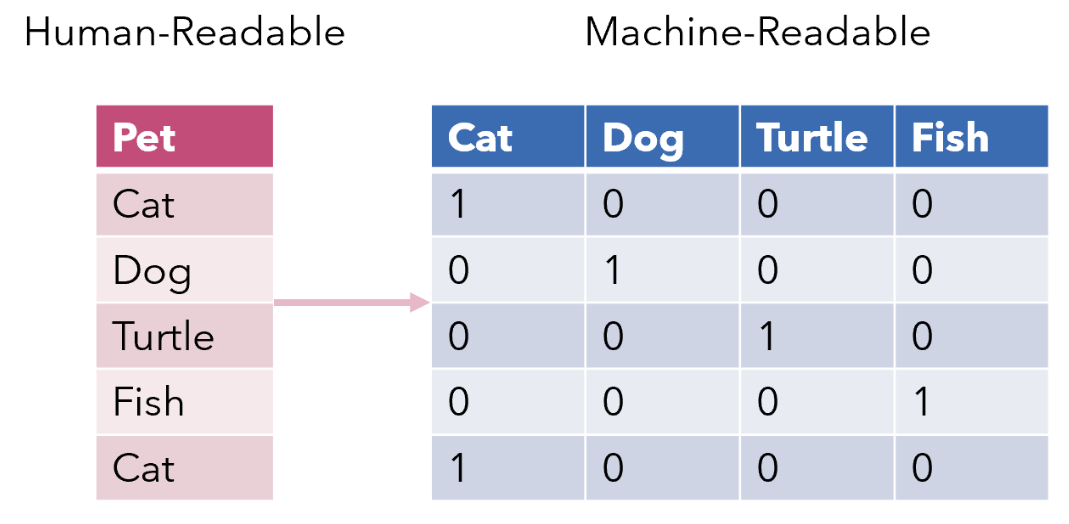

Quelle: Annuth, Hendrik, DeepLearning: Feature Engineering Folie 19, 2021

#### 4.3.1 Encoding der Extras

Eine Liste mit allen vorkommenden Extras wurde bereits extrahiert. Für jedes Tag dieser Extras wird eine Spalte angelegt. Wenn ein Tag auf ein Inserat zutrifft muss der Wert noch auf 1 gesetzt werden, ansonsten ist der Wert 0. Anschließend kann die Ursprüngliche Spalte Extras entfernt werden.

In [ ]:
#Für jedes Extra wird eine neue Spalte angelegt
for item in output:
    df3[item] = 0

#Für jedes vorhandene Extra einer Wohnung wird eine 1 gesetzt
counter = 0
for line in df3.Extras:
    for item in line:
        df3.at[counter,item] = 1
    counter += 1
#Jetzt wo alle Extras extrahiert wurden kann die ursprüngliche Spalte gelöscht werden
df3 = df3.drop("Extras",1)

#### 4.3.2 Encodin der Add-Ons

Auch bei vielen Spalten der Add-Ons ist es von Vorteil wenn bei diesen ein One-Hot Encoding sind.

In [ ]:
#Starting the one hot encoding
df4 = df3.copy()

#Ausstattung
dftemp = pd.get_dummies(df3.Ausstattung, prefix = "Ausstattung")
df4 = pd.concat([df4,dftemp], axis = 1).drop("Ausstattung", 1)

#Typ
dftemp = pd.get_dummies(df3.Typ, prefix = "Typ")
df4 = pd.concat([df4,dftemp], axis = 1).drop("Typ", 1)

#Zustand
dftemp = pd.get_dummies(df3.Objektzustand, prefix = "Zustand")
df4 = pd.concat([df4,dftemp], axis = 1).drop("Objektzustand", 1)
df4.Zustand_Saniert = df4.Zustand_Saniert + df4["Zustand_Erstbezug nach Sanierung"]
df4["Zustand_renoviert"] = df4["Zustand_Vollständig renoviert"]
df4.Zustand_Neuwertig = df4.Zustand_Neuwertig + df4.Zustand_Erstbezug
df4 = df4.drop(["Zustand_Nach Vereinbarung","Zustand_Erstbezug nach Sanierung","Zustand_Vollständig renoviert",
               "Zustand_Erstbezug"],1)

#Energieträger
dftemp = pd.get_dummies(df3["Wesentliche Energieträger"], prefix = "Energieträger")
df4 = pd.concat([df4,dftemp], axis = 1).drop("Wesentliche Energieträger", 1)

#Heizungsart
dftemp = pd.get_dummies(df3.Heizungsart, prefix = "Heizung")
df4 = pd.concat([df4,dftemp], axis = 1).drop("Heizungsart", 1)

#Einzugsbereit ab sofort/Zukunft
dftemp = pd.get_dummies(df3["Bezugsfrei ab"],prefix = "Einzug")
df4 = pd.concat([df4,dftemp], axis = 1).drop("Bezugsfrei ab", 1)


Zu guter letzt können die aufbereiteten Daten in eine CSV-Datei ("ImmoDatenAufbereitet.csv") Exportiert werden.

In [ ]:
df4.to_csv(path_or_buf = FolderPath + "ImmoDatenAufbereitet.csv",index = False, sep="|")

## 5. Explorative Datenanalyse

In [ ]:
#Import der im Kapitel benötigten Pakete
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

### 5.1 Grundlegendes

Durch die Aufbereitung der Daten im vorherigen Schritt müssen keine irrelevanten Spalten mehr gelöscht werden. Streng genommen muss auch nicht mehr geprüft werden, ob Null Werte enthalten oder die Datentypen korrekt sind. Der Vollständigkeit zu liebe werden diese beiden Schritte dennoch aufgeführt.

In [ ]:
df = pd.read_csv(FolderPath + "ImmoDatenAufbereitet.csv", sep = "|")

In [ ]:
#Gibt es null Werte im Dataframe?
df.isnull().values.any()

False

In [ ]:
#Welchen Datentyp haben die einzelnen Spalten?
df.dtypes

ID                                        int64
entfernung                              float64
Wohnfläche ca.                          float64
Zimmer                                  float64
Garage/ Stellplatz                        int64
Kaltmiete                               float64
Nebenkosten                             float64
Gesamtmiete                             float64
Nutzfläche ca.                          float64
Alter                                     int64
Online-Besichtigung möglich               int64
Keller                                    int64
Stufenloser Zugang                        int64
Einbauküche                               int64
Wohnberechtigungsschein erforderlich      int64
Personenaufzug                            int64
Balkon/ Terrasse                          int64
WG-geeignet                               int64
Gäste-WC                                  int64
Garten/ -mitbenutzung                     int64
Ausstattung_Einfache Qualität           

### 5.2 Visualisierung der Daten

Mithilfe von verschiedenen Grafiken können die Daten Abgebildet werden. Ziel ist es Verteilungen zu verstehen und Unregelmäßigkeiten oder Ausreißer zu identifizieren.

Im folgenden werden immer zuerst die Grafiken erzeugt und darunter unsere Beobachtungen festgehalten.

In [ ]:
df_vis = pd.read_csv(FolderPath + "ImmoDatenAufbereitet.csv", sep = "|")

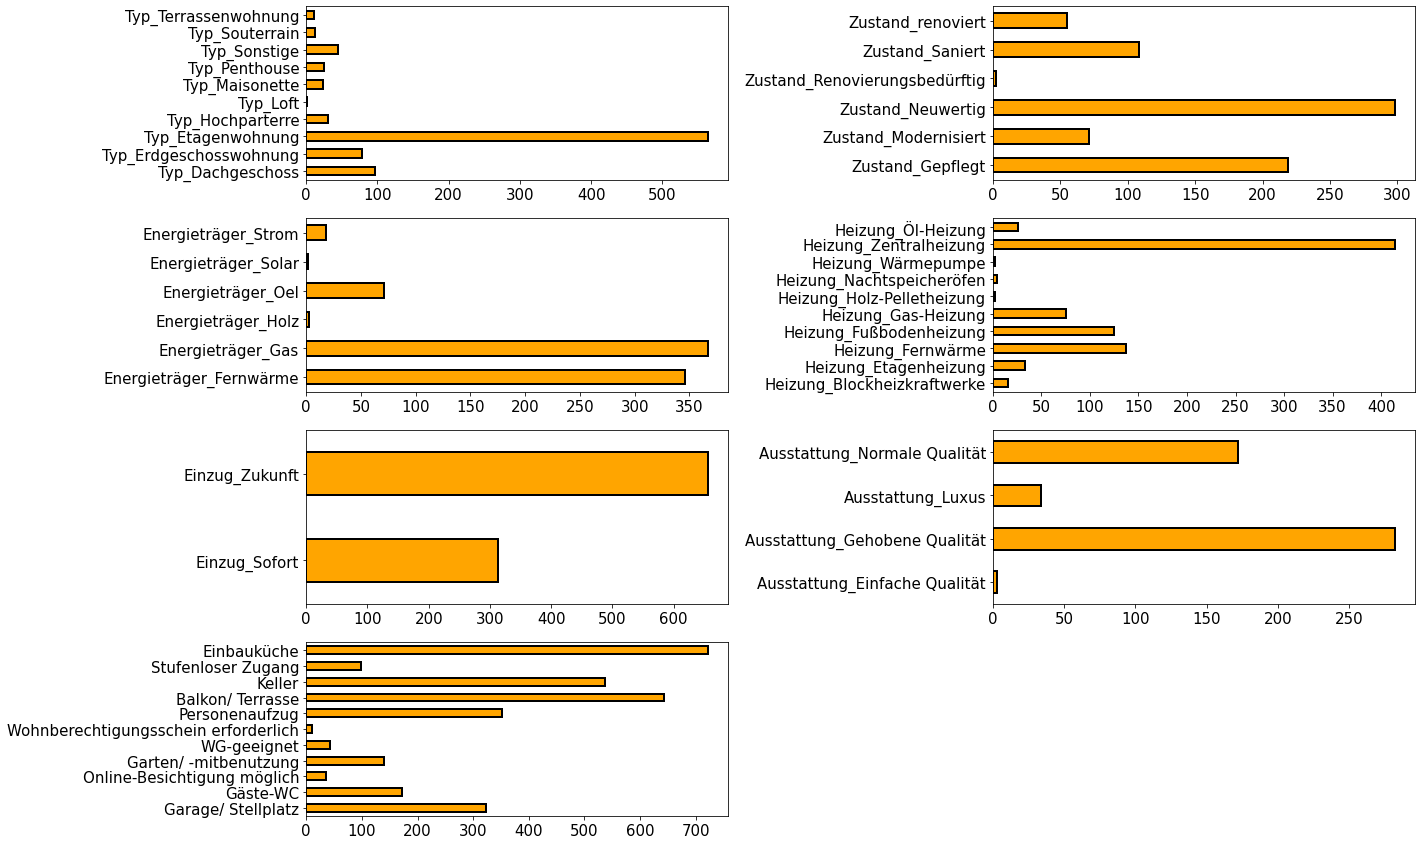

In [ ]:
Typ = ['Typ_Dachgeschoss', 'Typ_Erdgeschosswohnung', 'Typ_Etagenwohnung', 'Typ_Hochparterre', 'Typ_Loft', 'Typ_Maisonette', 'Typ_Penthouse', 'Typ_Sonstige', 'Typ_Souterrain', 'Typ_Terrassenwohnung']
Zustand = ['Zustand_Gepflegt', 'Zustand_Modernisiert', 'Zustand_Neuwertig', 'Zustand_Renovierungsbedürftig', 'Zustand_Saniert', 'Zustand_renoviert']
Energieträger = ['Energieträger_Fernwärme', 'Energieträger_Gas', 'Energieträger_Holz', 'Energieträger_Oel', 'Energieträger_Solar', 'Energieträger_Strom']
Heizung = ['Heizung_Blockheizkraftwerke', 'Heizung_Etagenheizung', 'Heizung_Fernwärme', 'Heizung_Fußbodenheizung', 'Heizung_Gas-Heizung', 'Heizung_Holz-Pelletheizung', 'Heizung_Nachtspeicheröfen', 'Heizung_Wärmepumpe', 'Heizung_Zentralheizung', 'Heizung_Öl-Heizung']
Einzug = ['Einzug_Sofort', 'Einzug_Zukunft']
Ausstattung = ['Ausstattung_Einfache Qualität', 'Ausstattung_Gehobene Qualität', 'Ausstattung_Luxus', 'Ausstattung_Normale Qualität']
Extras = ['Garage/ Stellplatz', 'Gäste-WC', 'Online-Besichtigung möglich', 'Garten/ -mitbenutzung', 'WG-geeignet', 'Wohnberechtigungsschein erforderlich', 'Personenaufzug', 'Balkon/ Terrasse', 'Keller', 'Stufenloser Zugang', 'Einbauküche']

Features = [Typ, Zustand, Energieträger, Heizung, Einzug, Ausstattung, Extras]


fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20,12))
#8ten Plot nicht anzeigen
axes[-1, -1].axis('off')

axx = 0
axy = 0
for Feature in Features:
  df_vis[Feature].sum().plot(width=0.5,
                             color="orange",
                             kind="barh",
                             edgecolor="black",
                             linewidth=2,
                             ax=axes[axy, axx])
  axy = axy + axx
  axx = int((axx + 1) % 2)

plt.tight_layout()


Beobachtungen aus den zuvor gezeigten Grafiken:

*   Einige Kategorien sind mit so wenigen Daten gefüllt, dass diese bei einem Training keine aussagekräftigen Ergbenisse liefern können



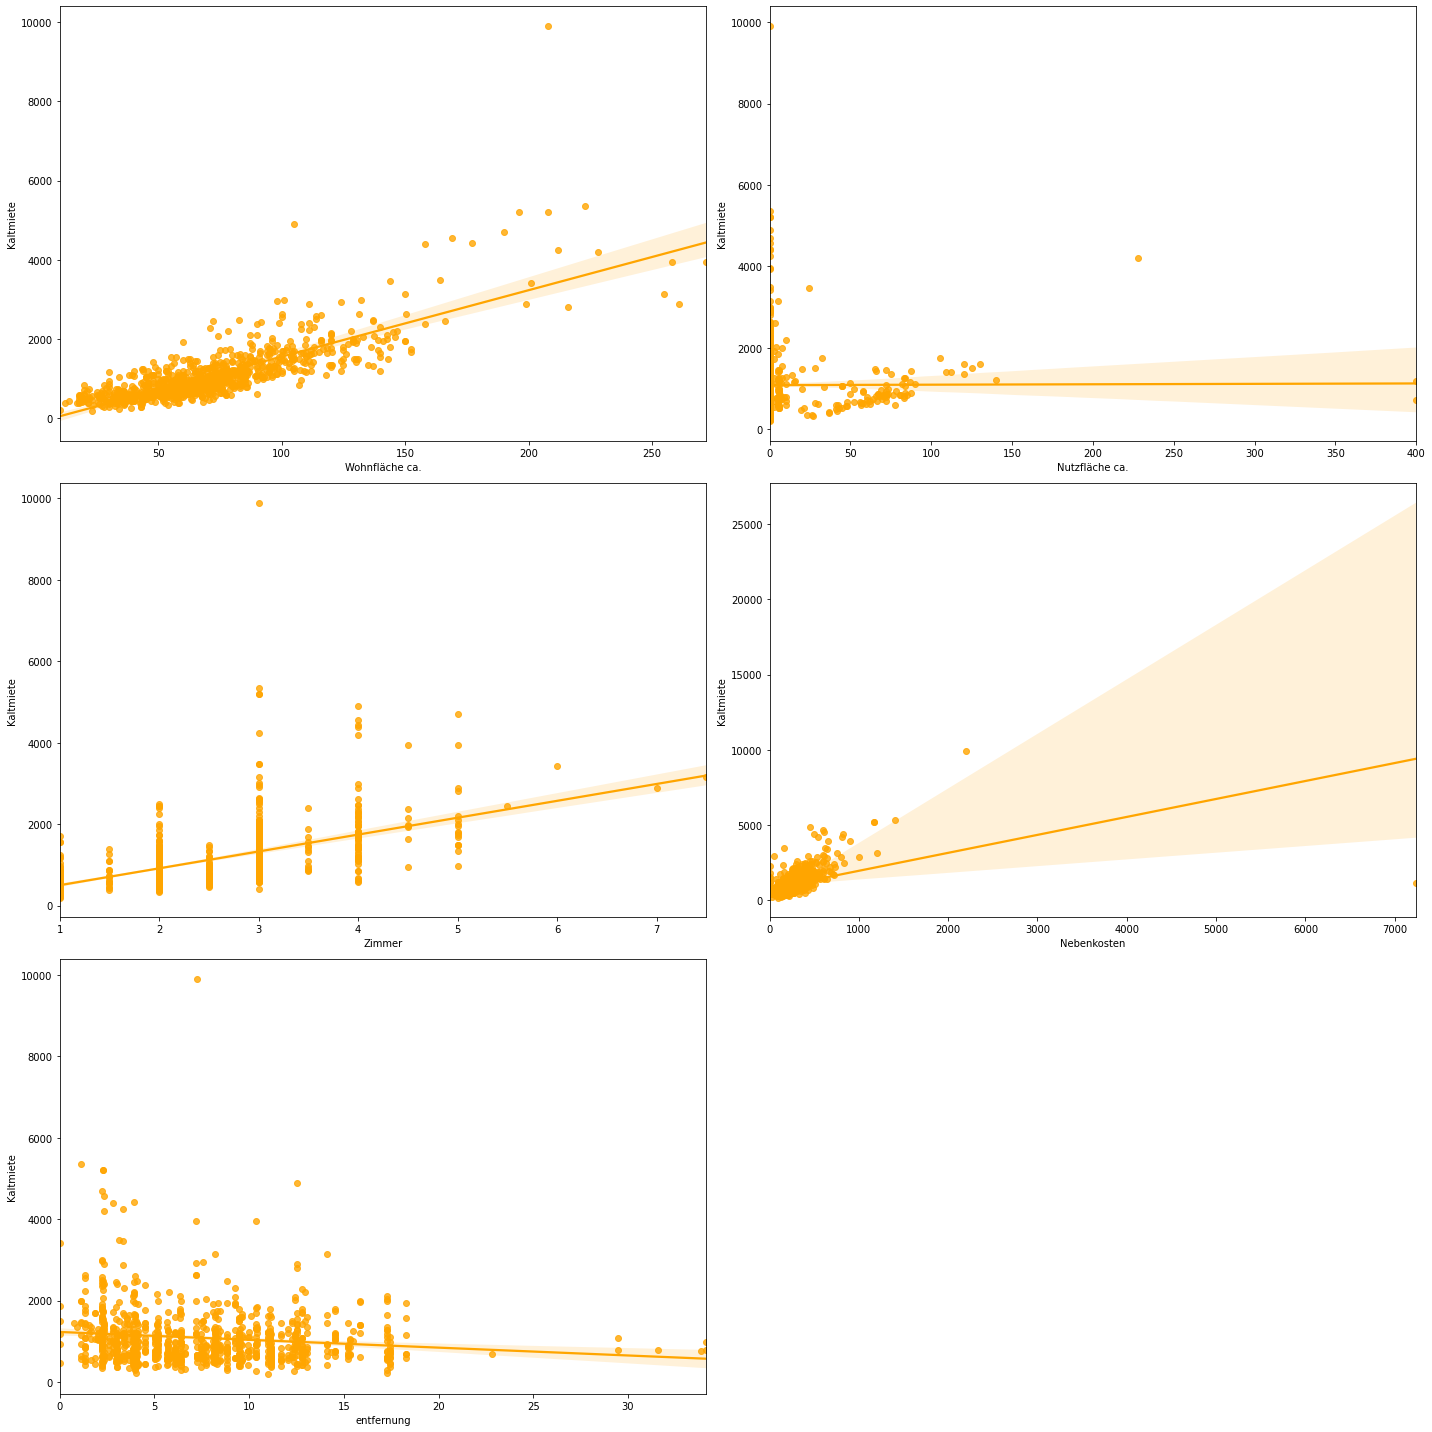

In [ ]:
FloatValues = ["Wohnfläche ca.", "Nutzfläche ca.", "Zimmer", "Nebenkosten", "entfernung"]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,20))

#6ten Plot nicht anzeigen
axes[-1, -1].axis('off')

axx = 0
axy = 0
for Feature in FloatValues:
  sns.regplot(x=Feature,
             y='Kaltmiete',
             data=df_vis,
             color = "orange",
             fit_reg=True,
             ax=axes[axy,axx])                     
  axy = axy + axx
  axx = int((axx + 1) % 2)
plt.tight_layout()

Beobachtungen aus den zuvor gezeigten Grafiken:


*   Es gibt eine Wohnung, welche sich in der Elbphilharmonie befindet und eine dementsprechend hohe Kaltmiete aufweißt.
*   Ein Inserat scheint viel zu hohe Nebenkosten zu haben. (über 7000€ für eine 3 Zimmerwohnung in Bahrenfeld. Inserat ist inzwischen gelöscht worden.)


Weitere Ausreißer lassen sich mit einem Boxplot bestimmen 

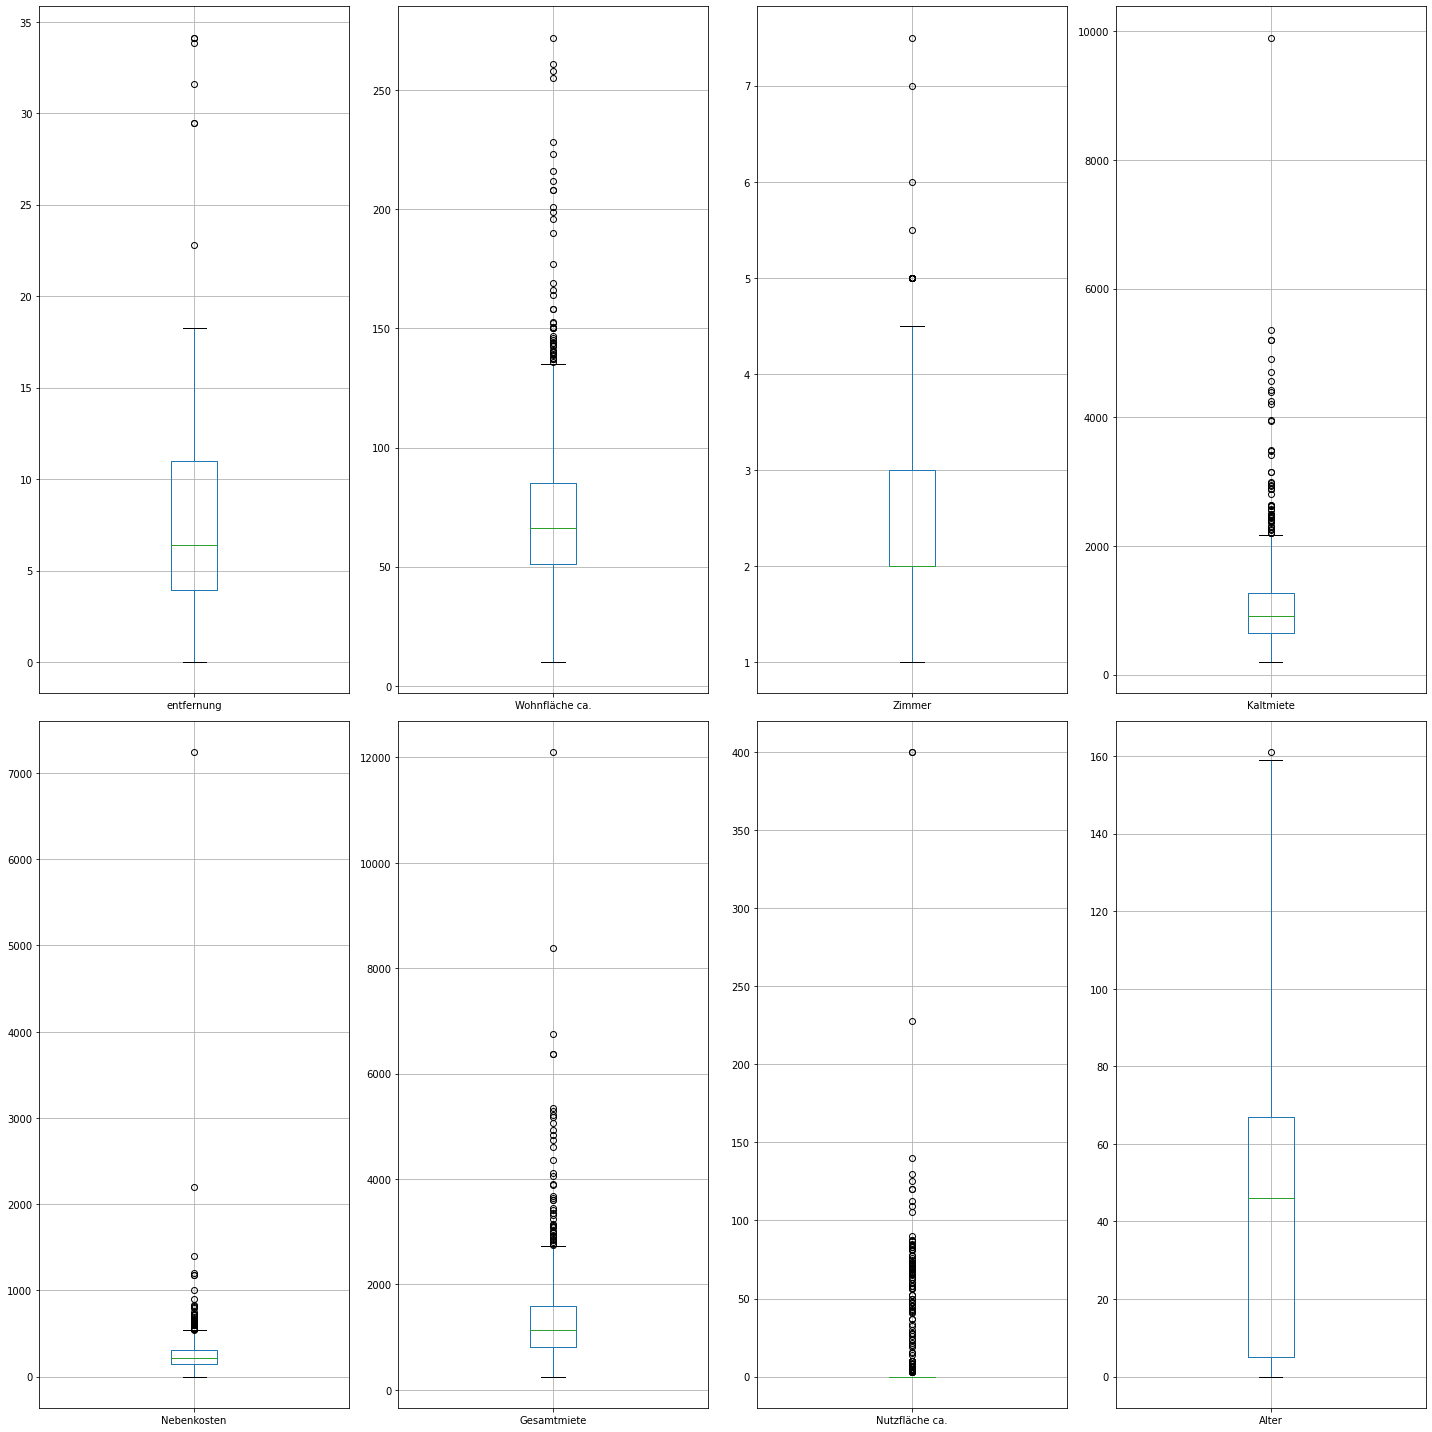

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20,20))

axx = 0
axy = 0

for column in df_vis.iloc[:,[1,2,3,5,6,7,8,9]]:
    df_vis.boxplot(column=[column],
                   ax=axes[axy,axx])
    axy = axy + int(axx / 3)
    axx = int((axx + 1) % 4)
plt.tight_layout()

### 5.3 Beseitigung der Ausreißer

Die Visualisierungen haben gezeigt, dass es einige Ausreißer in den Daten gibt. Diese sollen entfernt werden. Daher werden alle Inserate aus dem Dataframe entfernt, die

*   eine Kaltmiete von mehr als 6000 € haben.
*   mehr als 3000 € Nebenkosten haben.


Würden mehr Daten zur Verfügung stehen, wäre es eine Überlegung alle Werte außerhalb des 2,5% und 97,5% Quantils liegen zu entfernen.

Auf eine Visualiserung der bereinigten Daten wird an dieser Stelle der übersichtlichkeit halber verzichtet. Eine Änderung der zu ladenden Datei in 5.2 von "ImmoDatenAufbereitet.csv" zu "ImmoDatenbereinigt.csv" würde ausreichen, um sich diese anzusehen.

In [ ]:
df_cleaned = df_vis[(df_vis["Kaltmiete"] < 6000) & (df_vis["Nebenkosten"] < 3000)]

In [ ]:
#Typ_Loft zu Typ_Sonstige
df_cleaned.loc[(df_vis["Typ_Loft"] == 1), "Typ_Sonstige"] = 1
df_cleaned.loc[(df_vis["Typ_Loft"] == 1), "Typ_Loft"] = 0

#Heizung_Wärmepumpe, Nachtspeicheröfen und Holz-Pelletheizung zu Heizung_Sonstige zusammenfassen
df_cleaned.loc[(df_vis["Heizung_Wärmepumpe"] == 1), "Heizung_Sonstige"] = 1
df_cleaned.loc[(df_vis["Heizung_Nachtspeicheröfen"] == 1), "Heizung_Sonstige"] = 1
df_cleaned.loc[(df_vis["Heizung_Holz-Pelletheizung"] == 1), "Heizung_Sonstige"] = 1
df_cleaned.loc[(df_vis["Heizung_Wärmepumpe"] == 1), "Heizung_Wärmepumpe"] = 0
df_cleaned.loc[(df_vis["Heizung_Nachtspeicheröfen"] == 1), "Heizung_Nachtspeicheröfen"] = 0
df_cleaned.loc[(df_vis["Heizung_Holz-Pelletheizung"] == 1), "Heizung_Holz-Pelletheizung"] = 0

#Überflüssige Spalten entfernen
df_cleaned = df_cleaned.drop(["Typ_Loft", "Heizung_Wärmepumpe", "Heizung_Nachtspeicheröfen", "Zustand_Renovierungsbedürftig", "Wohnberechtigungsschein erforderlich", "Ausstattung_Einfache Qualität", "Energieträger_Holz", "Energieträger_Solar"], axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
df_cleaned.to_csv(path_or_buf = FolderPath + "ImmoDatenBereinigt.csv",index = False, sep="|")

## 6. Modellierung

### 6.1 Import der Packete und aufteilung des Datensatzes

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Als erstes werden die Daten aus der zwischengespeicherten CSV-Datei geladen.

In [ ]:
df = pd.read_csv(FolderPath + "ImmoDatenBereinigt.csv", sep = "|")

Der Datensatz wird in Regressoren und Regressand aufgeteilt.

In [ ]:
df_X = df
df_Y = df_X['Kaltmiete']
del df_X['ID']
del df_X['Kaltmiete']
del df_X['Gesamtmiete']


Aufteilung des Datensatzes in Trainings-, Test- und Validierungsdaten.

In [ ]:
X_trainVal, X_test, Y_trainVal, Y_test = train_test_split(df_X, df_Y, random_state=420) #test_size=0.15,
X_train, X_val, Y_train, Y_val = train_test_split(X_trainVal, Y_trainVal, random_state=420)

### 6.2 Multivariate Lineare Regression

Als erstes wird ein multivariates lineares Modell gebildet. Mit diesem können wir die Kaltmiete vorhersagen und es dient als Anfangsreferenzmodell, da es sich bei einer linearen Regression um ein sehr einfaches Modell handelt, soll dieses als eine Art Referenzwert für die Beurteilung der komplexeren Verfahren dienen.

Da n > 30 ist, nehmen wir Normalverteilung an. Außerdem nehmen wir die Annahmen eines Linearen Modells als gegeben an. (z.B. keine Strukturbrüche, Heteroskedastizität und Multikollinearität der Variablen)

In [ ]:
# Erstellung des Linearen Modells
regr = linear_model.LinearRegression(fit_intercept=True, normalize=True, copy_X=True)

# Trainieren des Modells
regr.fit(X_train, Y_train)

# Mithilfe des Modells die Trainingsdaten vorhersagen
Mietpreise_Y_pred = regr.predict(X_test)

# Koeffizienten des multivariaten Linearen Modells
print('Koeffizienten: \n', regr.coef_)

#Testdaten
print('Mittlere Quadratische Abweichung: %.2f'
      % mean_squared_error(Y_test, Mietpreise_Y_pred))
print('Testscore: %.2f'
      % r2_score(Y_test, Mietpreise_Y_pred))

#Trainingsdaten
Mietpreise_Y_pred = regr.predict(X_train)
print('Mittlere Quadratische Abweichung: %.2f'
      % mean_squared_error(Y_train, Mietpreise_Y_pred))
print('Trainingsscore: %.2f'
      % r2_score(Y_train, Mietpreise_Y_pred))
#83%

Koeffizienten: 
 [-1.80618288e+01  1.22734326e+01 -3.41452928e+01 -6.29616262e+01
  8.50247809e-01 -3.65982159e-01  1.20609270e+00  1.26989657e+02
 -3.02202027e+01  4.23631170e+01 -2.56446284e+01 -1.18856941e+02
  6.84446145e+01 -2.61524880e+02  7.99142980e+01  3.78159553e+01
 -2.36855647e+01 -3.93810972e+02  7.13672522e+01  3.09273118e+02
 -7.74196452e+01  6.33218925e+00 -3.26729439e+01 -2.45386433e+01
 -5.07752147e+01  4.54747351e-13 -4.35331076e+01 -4.64006984e+01
  1.94218649e+02 -8.46149197e+01 -4.07077249e+01  1.39183584e+01
  1.33728187e+02  1.08790283e+02 -3.67843605e+01  2.02026016e+02
  8.13224793e+01 -3.71296666e+01 -3.31268370e+00 -3.41060513e-13
 -6.43762793e+01  6.82018745e+01  1.86237442e+01 -1.72488717e+02
 -7.46258267e+01 -6.22788450e+01  7.23966749e+01 -8.27614278e+01
  1.13686838e-13 -1.52064512e+02  0.00000000e+00 -9.82795864e+01
 -4.36925735e+01  4.10083965e+00 -4.10083965e+00]
Mittlere Quadratische Abweichung: 93448.05
Testscore: 0.83
Mittlere Quadratische Abweich

Mit einem multivariaten linearen Modell erreichen wir ein Bestimmtheitsmaß von 0,8 auf unserem Datensatz und eine Mittlere quadratische Abweichung von ~93.000.

### 6.3. Grid Search

Die Performance von einem Modell hängt stark von den Hyperparametern ab. Aufgrund der oft hohen Anzahl an Hyperparametern und der daraus resultierenden Kombinationen sollen hier zwei Verfahren vorgestellt werden, die im folgenden genutzt werden.

Bei der Gridsearch Suche können einige optionen für jeden Hyperparameter angegeben werden. Es wird dann für jede Kombination ein Modell gebildet. Am Ende wird dann das Modell, welches die besten Ergebnisse liefert zurückgegeben.

Ein Problem dabei ist, dass die Werte für die Hyperparameter starr sind. so kann es passieren, dass ein Optimum übersprungen wird. Aus diesem Grund gibt es noch die zufällige Grid Search suche.
Hier werden nur Ober- und Untergrenzen für die Parameter angegeben. Es werden dann zufällige Werte ausprobiert (Vgl. folgende Abbildung). Dies kann zu einem besseren Ergebnis führen. Aus diesem Grund wird im folgenden hauptsächlich mit der zufälligen Gridsearch suche gearbeitet.
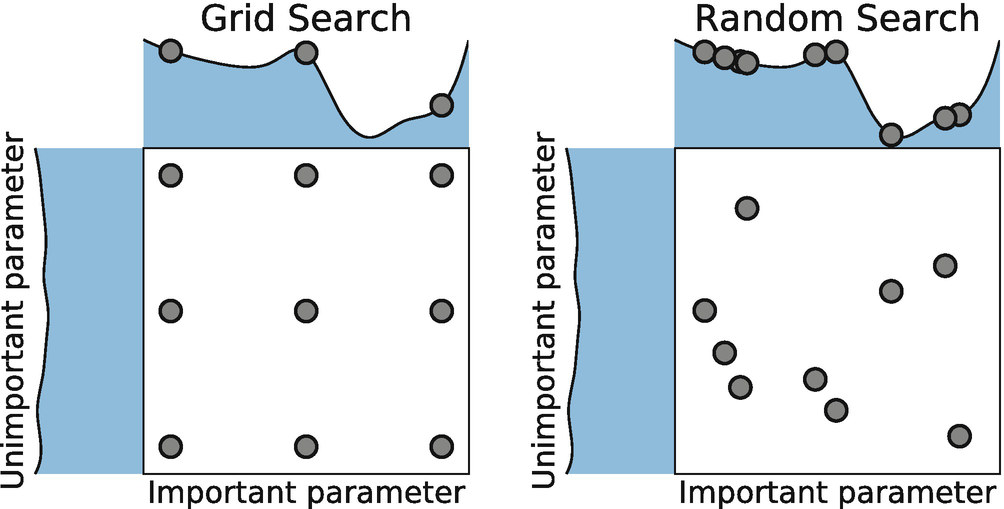

### 6.4. Verfahren

#### 6.4.1. Cheat Sheet

Neben der Linearen Regression sollen noch andere Verfahren zur Vorhersage der Kaltmiete betrachtet werden. Für eine grobe Eingrenzung der Verfahren wurde die folgende Grafik benutzt.








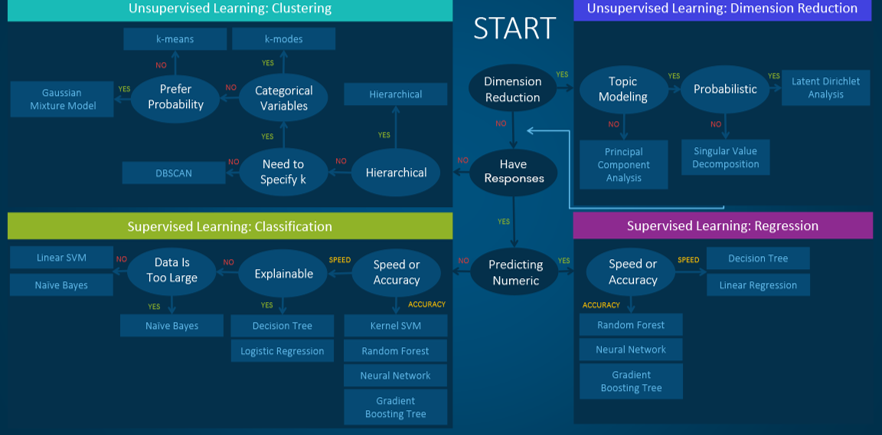

Folgt man dem Pfad vom Start landet man bei den Verfahren für "überwachtes Lernen: Regression". Da die Genauigkeit wichtiger ist als die Geschwindigkeit, stehen die folgendend drei Verfahren zur Verfügung:


*   Neuronales Netz
*   Random Forrest
*   Gradienten-Boosting 


#### 6.4.2. Auto ML mit "TPOT"

Das "Cheat Sheet" war ein erster Ansatz, Verfahren zu finden. Um noch weitere Ansätze ausfindig zu machen oder die Bisherigen zu bestätigen, haben wir uns von "TPOT" unterstützen lassen. Dies ist eine Biliothek aus dem Bereich AutoML und baut auf SciKit learn auf. Basierend auf den Daten kann getestet werden welches Verfahren sich am besten für eine Regression oder Klassifikation eignet.

Im folgenden wird "TPOT" genutzt, um deas beste Verfahren für die Mietpreisprognose auszuwählen. Der Output erfolgt als seperate Python Datei.

In [ ]:
from tpot import TPOTRegressor

In [ ]:
tpot = TPOTRegressor(generations=10, population_size=100, cv=5,
                                    random_state=42, verbosity=2)

tpot = TPOTRegressor(generations=500, population_size=200, verbosity=2, random_state=42, n_jobs = 10)
tpot.fit(X_train, Y_train.ravel())
print(tpot.score(X_test, Y_test))

tpot.export('tpot_exported_pipeline.py')

In der Ausgegebenen Datei lässt sich erkennen, dass TPOT als Verfahren die "Extra Trees"-Regression vorschlägt. Dies ist eine Abwandlung des Random Forrest.

Mit leicht Veränderten Parametern wird auch ein Neuronales Netz vorgeschlagen. Aus diesem Grund sollen im Folgenden diese beiden Verfahren näher beleuchtet werden. 

### 6.5. Multi-Layer Perceptron Regression

Das erste Verfahren ist ein Neuronales Netz. Scikit learn bietet hier die "Multi-layer Perceptron"-Regression (MLP) an.

MLP ist ein überwachter Lernalgorithmus, der eine Funktion "f" 
durch Training auf einem Datensatz erlernt, wobei $m$ die Anzahl der Dimensionen für die Eingabe und $o$ die Anzahl der Dimensionen für die Ausgabe ist. Bei einem Satz von Merkmalen $X = x_1, x_2,...,x_m$ und einem Ziel $y$ kann er einen nichtlinearen Funktionsapproximator entweder für die Klassifizierung oder die Regression lernen. Es unterscheidet sich von der logistischen Regression dadurch, dass es zwischen der Eingabe- und der Ausgabeschicht eine oder mehrere nichtlineare Schichten geben kann, die als versteckte Schichten bezeichnet werden. Die nachfolgende Abbildung zeigt einen MLP mit einer versteckten Schicht und skalarer Ausgabe.

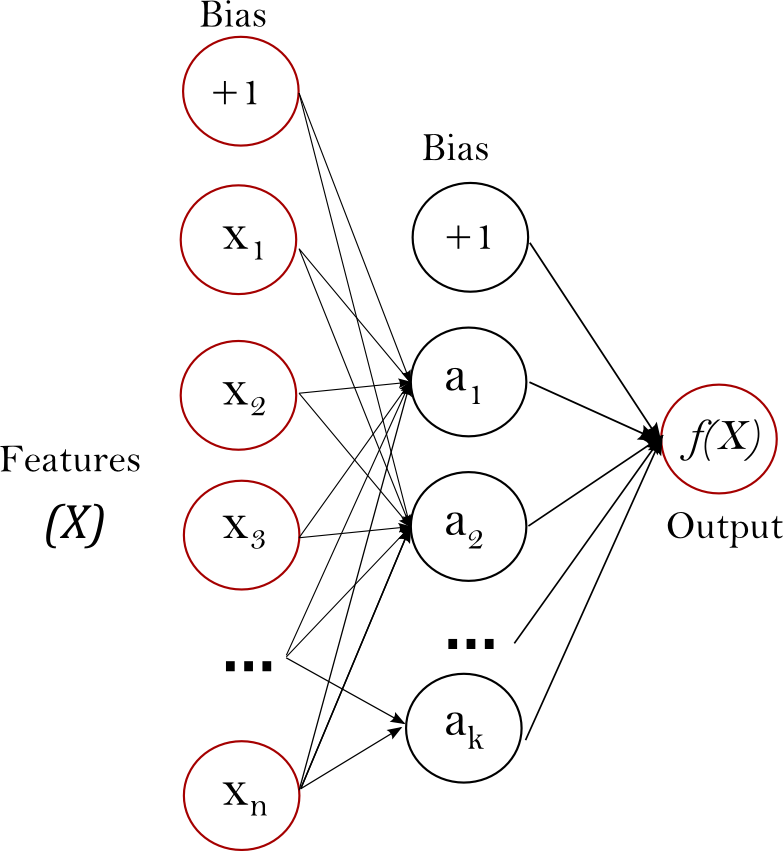

#### 6.5.1. Standard MLP-Regression

Es wird zunächst mit den Standardwerten für die Hyperparametern trainiert. Das Ergebnis kann später als ein weiterer Referenzwert dienen.

In [ ]:
#Testen mit Default werten
regr = MLPRegressor().fit(X_train, Y_train)
print("Testscore:",regr.score(X_test, Y_test))
print("Trainingsscore:",regr.score(X_train, Y_train))
print("Validierungsscore:",regr.score(X_val, Y_val))
##~76%

#### 6.5.2. Grid Search

Bei der "Multi-layer Perceptron"-Regression können verschiedene Funktionen für die Optimierung der Gewichte genutzt werden. Es werden 3 verschiedene Funktionen angeboten. Dabei ist sdg ein Gradientenverfahren und adam eine neuere verbesserte Version des sdg Gradientenverfahrens. Das dritte Verfahren ist lbfgs und basiert auf dem Newton Verfahren zum finden des Optimumns.

Für diese zwei Gruppen an Funktionen gibt es verschiedene Hyperparameter. Daher wird das Gridsearch in zwei Blöcke unterteilt. Im ersten wird eine optimale Lösung für das Gradientenfervahren Adam gesucht und im zweiten für den Ansatz mit dem Newton Verfahren lbfgs.

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from scipy.stats import randint
from random import uniform
from sklearn.utils.fixes import loguniform

##### 6.5.2.1. Random Gridsearch für Gradientenverfahren Adam:

In [ ]:
#Anlegen einer Liste mit den zu testenden Hyperparametern
parameters = {'hidden_layer_sizes': randint(50,500),
              'activation': ['identity', 'logistic', 'tanh', 'relu'],
              'solver': ['adam'],
              'alpha': loguniform(1e-5, 1e0),
              'batch_size': randint(50,400),
              'learning_rate_init':loguniform(1e-4, 4e-1),
              'max_iter': randint(500,15000),
              'shuffle': [True, False],
              'random_state': randint(1,100),
              'beta_1': loguniform(8e-1, 1e0),
              'beta_2': loguniform(9e-1, 1e0)}
              #'epsilon': loguniform(1e-7, 1e-9)}funktioniert aus irgendeinem Grund nicht
#Modelart
regrMlpAdam = MLPRegressor()

#Gridsearch
mlpAdam = RandomizedSearchCV(estimator=regrMlpAdam, param_distributions=parameters, n_iter=1000, cv=5, random_state=1, verbose=400, n_jobs=10, scoring='neg_mean_squared_error')
mlpAdam.fit(X_train, Y_train)

Die besten Parameter die durch die zufällige Suche gefunden wurden sind folgende.

In [ ]:
bestRegrAdam = mlpAdam.best_estimator_.fit(X_train, Y_train)
mlpAdam.best_params_

In [ ]:
regrAdam = MLPRegressor(activation = "relu",
                        alpha = 0.0984051790212445,
                        batch_size = 289,
                        beta_1 = 0.8229086712210736,
                        beta_2 = 0.9947503651520513,
                        hidden_layer_sizes = 214,
                        learning_rate_init = 0.00011375010085637372,
                        max_iter = 10166,
                        shuffle = True,
                        solver = "adam").fit(X_train, Y_train)
print("Testscore",regrAdam.score(X_test, Y_test))
print("Testscore",regrAdam.score(X_train, Y_train))

Erreicht sowohl auf dem Testset als auch auf dem Trainingsset einen sehr guten Score. Genauere Evaluirung erfolgt im 7. Kapitel.

##### 6.5.2.2. Random Gridsearch für Gradientenverfahren lbfgs:

Durchführen der zufälligen Gridsearch Suche.

In [ ]:
#Anlegen einer Liste mit den zu testenden Hyperparametern
parameters = {'hidden_layer_sizes': randint(50,500),
              'activation': ['identity', 'logistic', 'tanh', 'relu'],
              'solver': ['lbfgs'],
              'alpha': loguniform(1e-5, 1e0),
              'max_iter': randint(500,15000),
              'random_state': randint(1,100)}
#Modelart
Regressor = MLPRegressor()

#Gridsearch
mlpLbfgs = RandomizedSearchCV(estimator=Regressor, param_distributions=parameters, n_iter=500,
                              cv=5, random_state=1, verbose=400, n_jobs=9, scoring='neg_mean_squared_error')
mlpLbfgs.fit(X_train, Y_train)

Folgende besten Parameter gefunden:

In [ ]:
mlpLbfgs.best_params_

Ein Modell mit den besten parametern erreicht folgende Werte:

In [ ]:
regrLbfgs = MLPRegressor(activation="identity", alpha=1.541769298509513e-05, hidden_layer_sizes= 74, max_iter=674, random_state=21, solver="lbfgs").fit(X_train, Y_train)
#regrLbfgs = mlpLbfgs.best_estimator_.fit(X_train, Y_train)
print("Testscore:",regrLbfgs.score(X_test, Y_test))
print("Trainingsscore:",regrLbfgs.score(X_train, Y_train))

##### 6.5.2.4. Regulärer Grid Search

Zusätzlich wurde ein normaler Gridsearch durchgeführt, um sicherzugehen, dass wirklich keine Bereiche ausgelassen wurden und den Ergebnissen der zufälligen Gridsearchs vertraut werden kann.

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {'hidden_layer_sizes': [50, 100, 200, 500],
              'activation': ('identity', 'logistic', 'relu'),
              'solver': ('lbfgs', 'adam'),
              'alpha': [0.00001, 0.0001, 0.001],
              'learning_rate':('constant', 'invscaling', 'adaptive'), #nur für sdg solver
              'learning_rate_init': [0.0001, 0.001, 0.01],# nur für sdg oder adam
              'power_t': [0.1, 0.3 ,0.5], #nur für sdg
              'max_iter':[5000],    #[500, 1000, 2000, 5000, 10000],
              'shuffle': (True, False),#nur für sdg oder adam
              #'momentum': [0, 0.5, 1], #sdg
              'random_state': [1]}#sdg oder adam
#Modelart
Regressor = MLPRegressor()

#Gridsearch
clf = GridSearchCV(estimator=Regressor, param_grid=parameters, verbose=400, n_jobs=5, scoring='neg_mean_squared_error')
clf.fit(X_train, Y_train)

Das beste Modell nach dem Gridsearch hat folgende Parameter.

In [ ]:
clf.best_params_

Ein Modell mit den besten parametern erreicht folgende Werte:

In [ ]:
regrGridSearch = MLPRegressor(activation="relu", alpha=0.00001, learning_rate = "constant", learning_rate_init = 0.01, shuffle = True, solver="adam" ,random_state=1, max_iter=5000).fit(X_train, Y_train)
print("Testscore:",regrGridSearch.score(X_test, Y_test))
print("Trainingsscore:",regrGridSearch.score(X_test, Y_test))

Beim Vergleich der verschiedenen Gridsearch Verfahren hat sich gezeigt, dass ein Modell mit der Adam-Funktion für die Gewichte die besten Ergebnisse liefert. Außerdem konnte mit dem normalen Gridsearch ein besseres Modell errechnet werden. Dies liegt wahrscheinlich auch daran, dass hier knapp 20.000 verschiedenen Kombinationen ausprobiert wurden. Dies ist viel mehr als bei den zufälligen GridSearch Suchen.

#### 6.5.3 Anzahl der hidden Layer

Bisher wurde immer nur mit einem hidden Layer gearbeitet. Im folgenden wird überprüft, ob ein Netz mit mehreren hidden Layern besser performed.

Dabei muss darauf geachtet werden, dass der Datensatz relativ klein ist. So können mehrere Layer schnell dazu führen, dass das Netz die Daten auswändig lernt. Hinzu kommt, dass die Daten und Residuen normalvertielit sind und sich bereits gut durch eine lineare Regression abbilden lassen.

Trotzdem sollen die gefundenen Ergebnisse noch einmal mit verschiedenen Layer sizes ausprobiert werden. Dafür wird jeweils das beste Modell genommen und mit mehreren hidden Layern angereichert.

##### 6.5.3.1.MLP Regression mit Gradientenverfahren

Zunächst wird das beste Modell mit dem Gradientenverfahren betrachtet

In [ ]:
#Anlegen einer Liste mit den zu testenden Hyperparametern
parameters = {'activation': ['relu'],
              'hidden_layer_sizes': [(204),(204,204,204),(204,204,204,204),(204,204,204,204,204)],
              'alpha': [1e-05],
              'learning_rate': ['constant'],
              'learning_rate_init': [0.01],
              'max_iter': [5000],
              'momentum': [0],
              'random_state': [1],
              'shuffle': [True],
              'solver': ['adam']}

#Modelart
Regressor = MLPRegressor()

#Gridsearch
clf = GridSearchCV(estimator=Regressor, param_grid=parameters, verbose=400, n_jobs=5, scoring='neg_mean_squared_error')
clf.fit(X_train, Y_train)

Das Modell hat folgende Parameter:

In [ ]:
clf.best_params_

Das Modell zeigt, dass mit mehreren hidden Layern keine Verbesserung erreicht wird.

In [ ]:
regrGridSearch = clf.best_estimator_.fit(X_train, Y_train)
print("Testscore:",regrGridSearch.score(X_test, Y_test))
print("Trainingsscore:",regrGridSearch.score(X_test, Y_test))

##### 6.5.3.2. MLP Regression nach dem Ansatz von Newton

In [ ]:
#Anlegen einer Liste mit den zu testenden Hyperparametern
parameters = {'activation': ['identity'],
              'hidden_layer_sizes': [(74),(74,74,74),(74,74,74,74),(74,74,74,74,74)],
              'alpha': [1.541769298509513e-05],
              'max_iter': [674],
              'random_state': [21],
              'solver': ['lbfgs']}

#Modelart
Regressor = MLPRegressor()

#Gridsearch
clf = GridSearchCV(estimator=Regressor, param_grid=parameters, verbose=400, n_jobs=5, scoring='neg_mean_squared_error')
clf.fit(X_train, Y_train)

Das Modell hat folgende Parameter:

In [ ]:
clf.best_params_

Das Modell zeigt, dass mit mehreren hidden Layern keine Verbesserung erreicht wird.

In [ ]:
regrGridSearch = clf.best_estimator_.fit(X_train, Y_train)
print("Testscore:",regrGridSearch.score(X_test, Y_test))
print("Trainingsscore:",regrGridSearch.score(X_test, Y_test))

##### 6.5.3.3.Fazit

Wie bereits vermutet hat die anzahl der hidden Layer keinen bis nur sehr geringen Einfluss auf den Score auf den Testdaten. Dies kommt vor allem durch die geringe Anzahl an Daten und der guten Möglichkeit die Daten linear abzubilden.

### 6.5 Grafische Betrachtung des Modells

Im folgenden werden die Ergebnisse noch einmal genauer beleuchtet. Zunächst einmal macht es sinn die Partial Dependency genauer zu beleuchten.

In [ ]:
from sklearn.inspection import plot_partial_dependence
from matplotlib.pyplot import figure

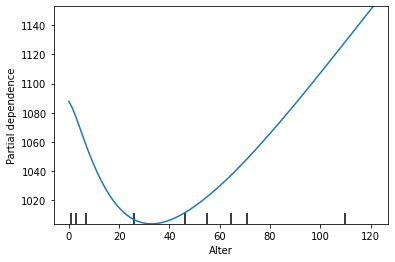

In [ ]:
plot_partial_dependence(regrAdam,df_X,["Alter"])

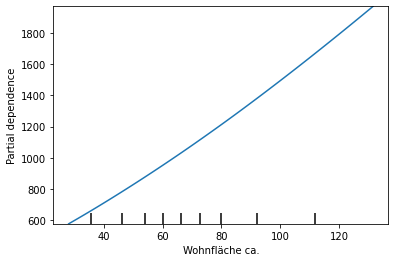

In [ ]:
plot_partial_dependence(regrAdam,df_X,["Wohnfläche ca."])

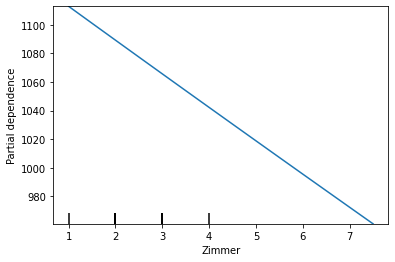

In [ ]:
plot_partial_dependence(regrAdam,df_X,["Zimmer"])

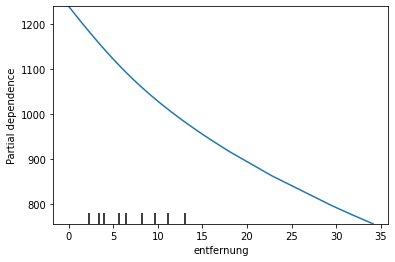

In [ ]:
plot_partial_dependence(regrAdam,df_X,["entfernung"])

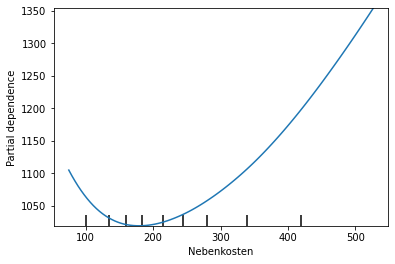

In [ ]:
plot_partial_dependence(regrAdam,df_X,["Nebenkosten"])

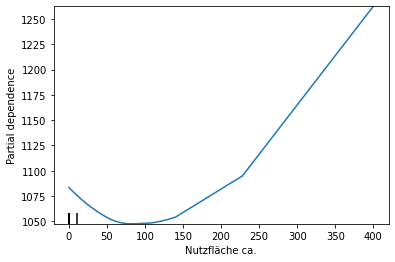

In [ ]:
plot_partial_dependence(regrAdam,df_X,["Nutzfläche ca."])

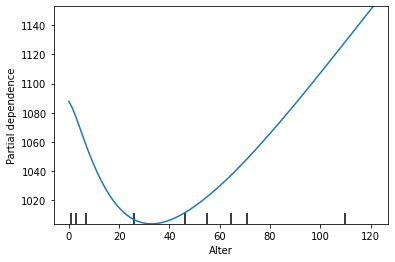

In [ ]:
plot_partial_dependence(regrAdam,df_X,["Alter"])

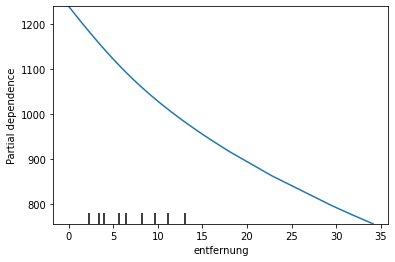

In [ ]:
plot_partial_dependence(regrAdam,df_X,["entfernung"])

Zusätzlich soll einmal der Lern-Fortschritt des Modells über die Lern-Iterationen (Epochs) betrachtet werden.

In [ ]:
regrGridSearch = MLPRegressor(activation="relu", alpha=0.00001, learning_rate = "constant", learning_rate_init = 0.01, shuffle = True, solver="adam" ,random_state=1, max_iter=50000) #max_iter ursprünglich 5000


Ergebnisse = {
    "Epoch": [],
    "Testscore": [],
    "Trainingsscore": [],
    "Validierungsscore": [] 
}

regrGridSearch.partial_fit(X_train, Y_train)
Ergebnisse["Epoch"].append(1)
Ergebnisse["Trainingsscore"].append(regrGridSearch.score(X_train, Y_train))
Ergebnisse["Testscore"].append(regrGridSearch.score(X_test, Y_test))
Ergebnisse["Validierungsscore"].append(regrGridSearch.score(X_val, Y_val))
#insgesamt 5.000 durchläufe, Grafik sieht auch nach 50.000 durchläufen noch ähnlich aus
for j in range(200):
  #alle 25 durchläufe den Fortschritt des Modells messen und festhalten
  for i in range(25):
    regrGridSearch.partial_fit(X_train, Y_train)
  Ergebnisse["Epoch"].append((j+1) * 25)
  Ergebnisse["Trainingsscore"].append(regrGridSearch.score(X_train, Y_train))
  Ergebnisse["Testscore"].append(regrGridSearch.score(X_test, Y_test))
  Ergebnisse["Validierungsscore"].append(regrGridSearch.score(X_test, Y_test))

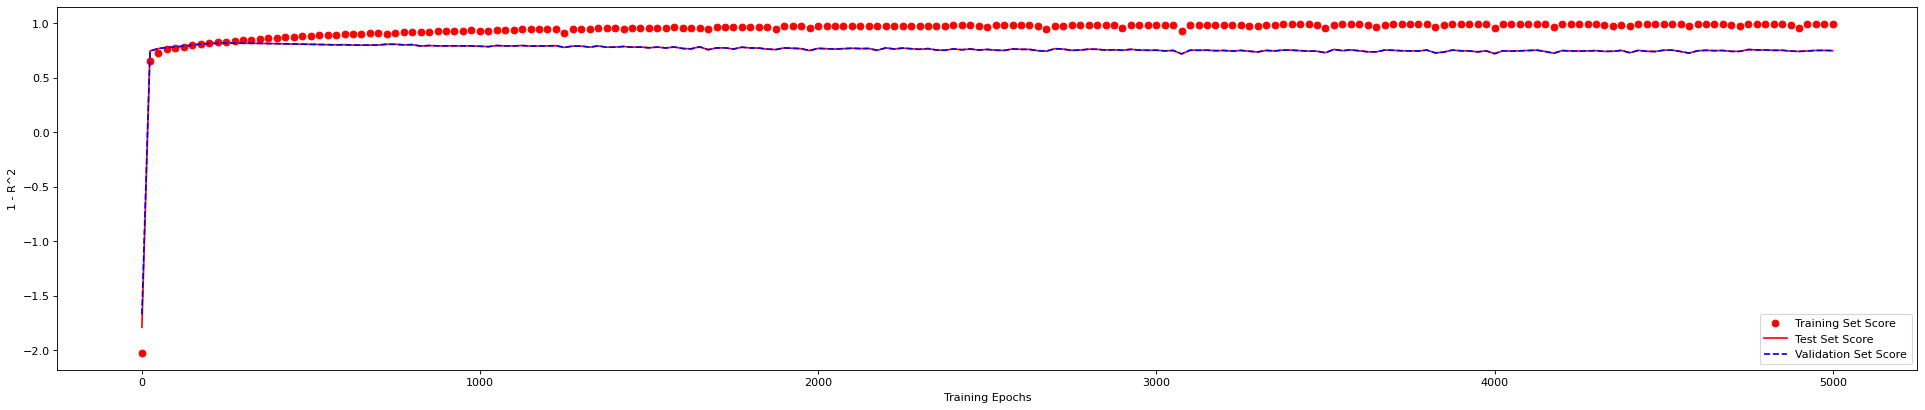

In [ ]:
figure(figsize=(30, 6), dpi=80)

#Durchläufe visualisieren
plt.plot(Ergebnisse['Epoch'], Ergebnisse['Trainingsscore'], 'ro', label='Training Set Score')
plt.plot(Ergebnisse['Epoch'], Ergebnisse['Testscore'], 'r', label='Test Set Score')
plt.plot(Ergebnisse['Epoch'], Ergebnisse['Validierungsscore'], 'b',linestyle='dashed', label='Validation Set Score')

plt.xlabel('Training Epochs')
plt.ylabel('1 - R^2')
plt.legend()

Der Graph zeigt, dass unsere Lösung, welche wir mit dem Grid Search gefunden haben ein gutes Ergebnis bezüglich der Epochen zu sein. So sollen wir ca. 2400 Epochen durchführen. Ab diesem Punkt kann man im Grafen auch keine starke veränderung mehr erkennen. Hnzu kommt, dass eine Veränderung auch schon durch die Varianz der Batches hervorgerufen werden kann. Aus diesem Grund ist eine Optimierung über diesen Punkt hinaus nur bedingt sinvoll.

### 6.6. Extra Trees Regression

TPOT hat als bestes Modell die "Extra Trees"-Regression vorgeschlagen. Wie bereits erwähnt ist dies eine Abwandlung des Random Forrest. Das Vorgehen ist ähnlich zur MLP-Regression. Zuerst wird ein Modell mit den Standardwerten gebildet. Anschließend wird dieser Referenzwert benutz um die Ergebnisse des zufälligen Gridsearch zu bewerten.

#### 6.6.1 Standard Extra Trees Regression

Die Standardwerte liefern bereits bessere Werte als die multivariate Lineare Regression und kommen dicht an die MLP-Regression ran.

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor


regrETrees = ExtraTreesRegressor().fit(X_train, Y_train)

regrETrees.score(X_test, Y_test)

In [ ]:
regrETrees.score(X_train, Y_train)

Der Standard Extra Tree Regressor performed serh gut auf den Testdaten. Das Problem ist nur, dass es keine Grenze für ein Blatt gibt. Dies führt dazu, dass das Modell schnell overfitted.

#### 6.6.2 Gridsearch

Gridsearch ist bereits unter 6.3. ausführlich erklärt. Aus diesem Grund wird an dieser stelle auf eine erneute Erklärung verzichtet.

In [ ]:
from scipy.stats import randint
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
#Anlegen einer Liste mit den zu testenden Hyperparametern
parameters = {"n_estimators": randint(50,500),
              "criterion" : ["mse", "mae"],
              #"max_depth" : randint(20,500),
              #"min_sample_split": randint(2,20),
              "min_samples_leaf": randint(1, 20),
              #"min_weight_fraction_leaf": loguniform(0e0,1e0),
              "max_features": loguniform(2e-1,1e0),
              #"max_leaf_nodes": randint(20,500),
              #"min_impurity_decrease": loguniform(0e0,1e0),
              "bootstrap": [True, False],
              "random_state": randint(1,42)
              #"ccp_alpha":loguniform(0e0,1e0)
              }
#Modelart
Regressor = ExtraTreesRegressor()

#Gridsearch
eTrees = RandomizedSearchCV(Regressor, param_distributions=parameters,
                       cv=5,
                       n_iter=1000,
                       n_jobs=9,
                       verbose=400)
eTrees.fit(X_train, Y_train)

In [ ]:
eTrees.best_params_

In [ ]:
regrs = eTrees.best_estimator_.fit(X_train, Y_train)
print("Score on Testset:", regrs.score(X_test,Y_test))
print("Score on Trainset:", regrs.score(X_train,Y_train))

Das beste Modell hat einen guten score auf dem Testset, aber scheint die Trainingsdaten auswendig gelernt zu haben. Daher wird das Modell wie folgt empirisch abgeändert.

In [ ]:
regrs = ExtraTreesRegressor(bootstrap=False,criterion="mse",max_features=0.9,min_samples_leaf=4,n_estimators=500).fit(X_train, Y_train)
print("Score on Testset:", regrs.score(X_test,Y_test))
print("Score on Trainset:", regrs.score(X_train,Y_train))

Das Modell erreicht einen guten score auf dem Trainings- und Testdaten.

Aus den Ergebnissen des Standard Extra Tree Regressors und dem zufälligen Gridsearch lässt sich das folgende Modell bauen. Dieses erreicht leider schlechtere Werte als die multivariate Lineare Regression.

In [ ]:
regTPOT = ExtraTreesRegressor(bootstrap=False, max_features=0.5, min_samples_leaf=4, min_samples_split=10, n_estimators=100).fit(X_train,Y_train)
print(regTPOT.score(X_test,Y_test))
print(regTPOT.score(X_train,Y_train))

Performed auf dem Testset etwas schlechter als die Multivariate lineare Regression und MLP-Regression. Allerdings performed das Modell besser auf dem Testset als die Lineare Regression.

Es scheint so als ob, der Extra Trees regressor, mit den Standardwerten , die besten Ergebnisse liefert. Daher wird aus dem Standardmodell, welches noch nicht beschnitten wurde und den Ergebnissen des zufalls Gridsearch gebildet. Das Modell erreicht einen Score von 81% auf den Testdaten.

In [ ]:
Regressor = ExtraTreesRegressor(n_estimators=500,criterion="mse",min_samples_leaf=5)
Regressor.fit(X_train,Y_train)
Regressor.score(X_test,Y_test)

### 6.7. Gradient Boosting Tree

Ein weiteres Verfahren, welches vom Cheat-Sheet vorgeschlagen wurde ist der Gradient Boosting Tree. Es ist eine Abwandlung des Random Forest und erziehlt für gewöhnlich bessere Ergebnisse. Die Idee ist, dass iterativ Bäume gebaut werden. Der neue Baum versucht immer den Fehler des letzten Baumes zu minimieren.

Das Verfahren besteht also hauptsächlich aus zwei Schritten. Zunächst wird ein irgendwie geartetes Modell erstellt. Bei Regression ist dieses z.B. die Normalverteilung. Dieses Modell sagt den Hauspreis voraus. Bei der überprüfung, stellen wir aber fest, das Haus ist eigentlich 400k wert. Das Modell hat aber nur 200K vorhergesagt. Dann bauen wir einen neuen Baum. Dieser versucht jetzt nicht den Hauspreis vorherzusagen, sondern den Fehler des Modells.

#### 6.7.1 Gridsearch

In [ ]:
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
#Anlegen einer Liste mit den zu testenden Hyperparametern
parameters = {'loss': ['ls', 'lad', 'huber', 'quantile'],
              'learning_rate': loguniform(1e-4, 2e-1),
              'n_estimators': randint(50,400),
              'subsample': loguniform(9e-1, 11e-1),
              'min_samples_leaf': randint(3,20),
              'random_state': randint(1,100),
              'alpha': loguniform(8e-1, 1e0)}
#Modelart
regrGBR = GradientBoostingRegressor()

#Gridsearch
Search = RandomizedSearchCV(estimator=regrGBR, param_distributions=parameters, n_iter=2500, cv=5, random_state=1, verbose=400, n_jobs=10, scoring='neg_mean_squared_error')
Search.fit(X_train, Y_train)

Fitting 5 folds for each of 2500 candidates, totalling 12500 fits


C:\Users\Space\.conda\envs\scikit\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [-166214.57723811              nan              nan ... -161990.53594538
 -676010.29790595              nan]
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_iter=2500,
                   n_jobs=10,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000261AD26F190>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000261AC27BC70>,
                                        'loss': ['ls', 'lad', 'huber',
                                                 'quantile'],
                                        'min_samples_leaf': <scipy.stats._distn...zen object at 0x00000261AD263FA0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000261ABCC18E0>,
                                        'random_state': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000261AD263DF0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000261A6D

Die Besten Parameter sind:

In [ ]:
Search.best_params_

{'alpha': 0.939172792746644,
 'learning_rate': 0.06954145170602204,
 'loss': 'ls',
 'min_samples_leaf': 6,
 'n_estimators': 166,
 'random_state': 28,
 'subsample': 0.9597978557688435}

In [ ]:
gradienatBT = GradientBoostingRegressor(alpha= 0.939172792746644,
                                               learning_rate= 0.06954145170602204,
                                               loss= 'ls',
                                               min_samples_leaf= 6,
                                               n_estimators= 166,
                                               random_state= 28,
                                               subsample = 0.9597978557688435).fit(X_train,Y_train)

Dadurch ergeben sich folgende Metriken:

In [ ]:
print("Testscore:", gradienatBT.score(X_test ,Y_test))
print("Trainingsscore:", gradienatBT.score(X_train ,Y_train))

Testscore: 0.9004773380107399
Trainingsscore: 0.9376242213742181


In [ ]:
print('Mittlere Quadratische Abweichung: %.2f'
      % mean_squared_error(Y_train, gradienatBT.predict(X_train)))

print('Mittlere Quadratische Abweichung: %.2f'
      % mean_squared_error(Y_test, gradienatBT.predict(X_test)))

Mittlere Quadratische Abweichung: 23821.47
Mittlere Quadratische Abweichung: 53659.74


### 6.9. Ensemble  Learning

Ohne das Lineare Modell wurden bisher 3 Modelle erstellt, welche gute Ergebnisse geliefert haben. Nun ist die Überlegung per Abstimmung der drei Modelle das Ergebnis noch weiter zu verbessern. Das bedeutet es müssen alle drei Modelle trainiert werden. und das Ergebnis ist dann der Durchschnitt der drei Prognosen.

In [ ]:
from sklearn.ensemble import VotingRegressor

Im ersten Schritt speichern wir die bisher drei besten Modelle noch einmal ab.

In [ ]:
reg1 = GradientBoostingRegressor(alpha= 0.939172792746644,
                                               learning_rate= 0.06954145170602204,
                                               loss= 'ls',
                                               min_samples_leaf= 6,
                                               n_estimators= 166,
                                               random_state= 28,
                                               subsample = 0.9597978557688435).fit(X_train,Y_train)

reg2 = ExtraTreesRegressor(bootstrap=False,criterion="mse",max_features=0.9,min_samples_leaf=4,n_estimators=500).fit(X_train, Y_train)

reg3 = MLPRegressor(activation="relu", alpha=0.00001, learning_rate = "constant", learning_rate_init = 0.01, shuffle = True, solver="adam" ,random_state=1, max_iter=5000).fit(X_train, Y_train)

Diese Modelle nutzen wir dann um unseren Voting Regressor für das ensemble learning zu trainieren.

In [ ]:
ereg = VotingRegressor([('gb', reg1), ('rf', reg2), ('lr', reg3)])
ereg.fit(X_train, Y_train)

VotingRegressor(estimators=[('gb',
                             GradientBoostingRegressor(alpha=0.939172792746644,
                                                       learning_rate=0.06954145170602204,
                                                       min_samples_leaf=6,
                                                       n_estimators=166,
                                                       random_state=28,
                                                       subsample=0.9597978557688435)),
                            ('rf',
                             ExtraTreesRegressor(max_features=0.9,
                                                 min_samples_leaf=4,
                                                 n_estimators=500)),
                            ('lr',
                             MLPRegressor(alpha=1e-05, learning_rate_init=0.01,
                                          max_iter=5000, random_state=1))])

Dadurch ergeben sich folgende Metriken:

In [ ]:
print("Trainingsscore:",ereg.score(X_train,Y_train))
print("Testscore:", ereg.score(X_test,Y_test))

Trainingsscore: 0.9339561502508873
Testscore: 0.8934751580084302


Wir konnten die Performance des Modells noch einmal verbessern. Eine genauere Betrachtung der Ergebnisse erfolgt im Kapitel 7.



## 7. Evaluierung

### 7.1. Vergleich des Scores / Mean Squared Error

Es gibt nun drei verschiedene Modelle, welche miteinander verglichen werden sollen. Die verschiedenene Modelle werden zunächst mithilfe des Test-, Trainings- und Validierungsscores verglichen. So kann überprüft werden, wie gut die Modelle auch auf neuen Daten performen. 

#### 7.1.1 Multivariate Lineare Regression

In [ ]:
Mietpreise_Y_pred = regr.predict(X_test)
#Testdaten
print('Mittlere Quadratische Abweichung: %.2f'
      % mean_squared_error(Y_test, Mietpreise_Y_pred))
print('Testscore: %.2f'
      % r2_score(Y_test, Mietpreise_Y_pred))
#Trainingsdaten
Mietpreise_Y_pred = regr.predict(X_train)
print('Mittlere Quadratische Abweichung: %.2f'
      % mean_squared_error(Y_train, Mietpreise_Y_pred))
print('Trainingsscore: %.2f'
      % r2_score(Y_train, Mietpreise_Y_pred))
#Validierungsdaten
Mietpreise_Y_pred = regr.predict(X_val)
print('Mittlere Quadratische Abweichung: %.2f'
      % mean_squared_error(Y_val, Mietpreise_Y_pred))
print('Trainingsscore: %.2f'
      % r2_score(Y_val, Mietpreise_Y_pred))

Mittlere Quadratische Abweichung: 93448.05
Testscore: 0.83
Mittlere Quadratische Abweichung: 78018.20
Trainingsscore: 0.80
Mittlere Quadratische Abweichung: 122271.40
Trainingsscore: 0.71


#### 7.1.2. MLP Regression:

In [ ]:
#Testdaten
print('Mittlere Quadratische Abweichung: %.2f'
      % mean_squared_error(Y_test, regrGridSearch.predict(X_test)))
print('Testscore: %.2f'
      % regrGridSearch.score(X_test, Y_test))

#Trainingsdaten
print('Mittlere Quadratische Abweichung: %.2f'
      % mean_squared_error(Y_train, regrGridSearch.predict(X_train)))
print('Trainingsscore: %.2f'
      % regrGridSearch.score(X_train, Y_train))

#Validierungsdaten
print('Mittlere Quadratische Abweichung: %.2f'
      % mean_squared_error(Y_val, regrGridSearch.predict(X_val)))
print('Trainingsscore: %.2f'
      % regrGridSearch.score(X_val,Y_val))

Mittlere Quadratische Abweichung: 61887.29
Testscore: 0.89
Mittlere Quadratische Abweichung: 35178.23
Trainingsscore: 0.89
Mittlere Quadratische Abweichung: 105563.34
Trainingsscore: 0.75


#### 7.1.3. Extra Trees Regression:

In [ ]:
regrETrees = ExtraTreesRegressor(bootstrap=False,criterion="mse",max_features=0.9,min_samples_leaf=4,n_estimators=500).fit(X_train, Y_train)
#Testdaten
print('Mittlere Quadratische Abweichung: %.2f'
      % mean_squared_error(Y_test, regrETrees.predict(X_test)))
print('Testscore: %.2f'
      % regrETrees.score(X_test, Y_test))

#Trainingsdaten
print('Mittlere Quadratische Abweichung: %.2f'
      % mean_squared_error(Y_train, regrETrees.predict(X_train)))
print('Trainingsscore: %.2f'
      % regrETrees.score(X_train, Y_train))

#Validierungsdaten
print('Mittlere Quadratische Abweichung: %.2f'
      % mean_squared_error(Y_val, regrETrees.predict(X_val)))
print('Trainingsscore: %.2f'
      % regrETrees.score(X_val,Y_val))

Mittlere Quadratische Abweichung: 96349.84
Testscore: 0.82
Mittlere Quadratische Abweichung: 35403.63
Trainingsscore: 0.91
Mittlere Quadratische Abweichung: 128957.70
Trainingsscore: 0.70


#### 7.1.3. Gradient Boosting Tree:

In [ ]:
regrETrees = GradientBoostingRegressor(alpha= 0.939172792746644,
                                               learning_rate= 0.06954145170602204,
                                               loss= 'ls',
                                               min_samples_leaf= 6,
                                               n_estimators= 166,
                                               random_state= 28,
                                               subsample = 0.9597978557688435).fit(X_train,Y_train)
#Testdaten
print('Mittlere Quadratische Abweichung: %.2f'
      % mean_squared_error(Y_test, regrETrees.predict(X_test)))
print('Testscore: %.2f'
      % regrETrees.score(X_test, Y_test))

#Trainingsdaten
print('Mittlere Quadratische Abweichung: %.2f'
      % mean_squared_error(Y_train, regrETrees.predict(X_train)))
print('Trainingsscore: %.2f'
      % regrETrees.score(X_train, Y_train))

#Validierungsdaten
print('Mittlere Quadratische Abweichung: %.2f'
      % mean_squared_error(Y_val, regrETrees.predict(X_val)))
print('Trainingsscore: %.2f'
      % regrETrees.score(X_val,Y_val))

Mittlere Quadratische Abweichung: 53659.74
Testscore: 0.90
Mittlere Quadratische Abweichung: 23821.47
Trainingsscore: 0.94
Mittlere Quadratische Abweichung: 106336.06
Trainingsscore: 0.75


#### 7.1.4. Voting Regressor (Ensemble Learning):

In [ ]:
ereg = VotingRegressor([('gb', reg1), ('rf', reg2), ('lr', reg3)]).fit(X_train, Y_train)
#Testdaten
print('Mittlere Quadratische Abweichung: %.2f'
      % mean_squared_error(Y_test, ereg.predict(X_test)))
print('Testscore: %.2f'
      % ereg.score(X_test, Y_test))

#Trainingsdaten
print('Mittlere Quadratische Abweichung: %.2f'
      % mean_squared_error(Y_train, ereg.predict(X_train)))
print('Trainingsscore: %.2f'
      % ereg.score(X_train, Y_train))

#Validierungsdaten
print('Mittlere Quadratische Abweichung: %.2f'
      % mean_squared_error(Y_val, ereg.predict(X_val)))
print('Trainingsscore: %.2f'
      % ereg.score(X_val,Y_val))

Mittlere Quadratische Abweichung: 57187.44
Testscore: 0.89
Mittlere Quadratische Abweichung: 25245.36
Trainingsscore: 0.93
Mittlere Quadratische Abweichung: 100830.09
Trainingsscore: 0.76


#### 7.1.5. Zusammenfassung

Die Ergebnisse lassen sich auch gut in einer Tabelle darstellen.

| Modell | Trainingsscore / MSE | Testscore / MSE | Validierungsscore / MSE |
| :--- | ---: | ---: | ---: |
| Multivariate lineare Regression | 83% / 93448.05 | 80% / 78018.20 | 71% / 122271.40  | 
| MLP Regression | 89% / 35178.23 | 88% / 60110.93 | 75% / 105563.34 |
| ExtraTrees | 83% / 34011.94 | 83% / 92691.91 | 70% / 129302 |
|Gradient Boosting Tree| 94% / 23821.47| 90% / 53659.74 | 75% / 106336.06|
| Voting Regressor | 93 % / 25245.36 | 89% / 57187.44 | 76% / 100830.09 |


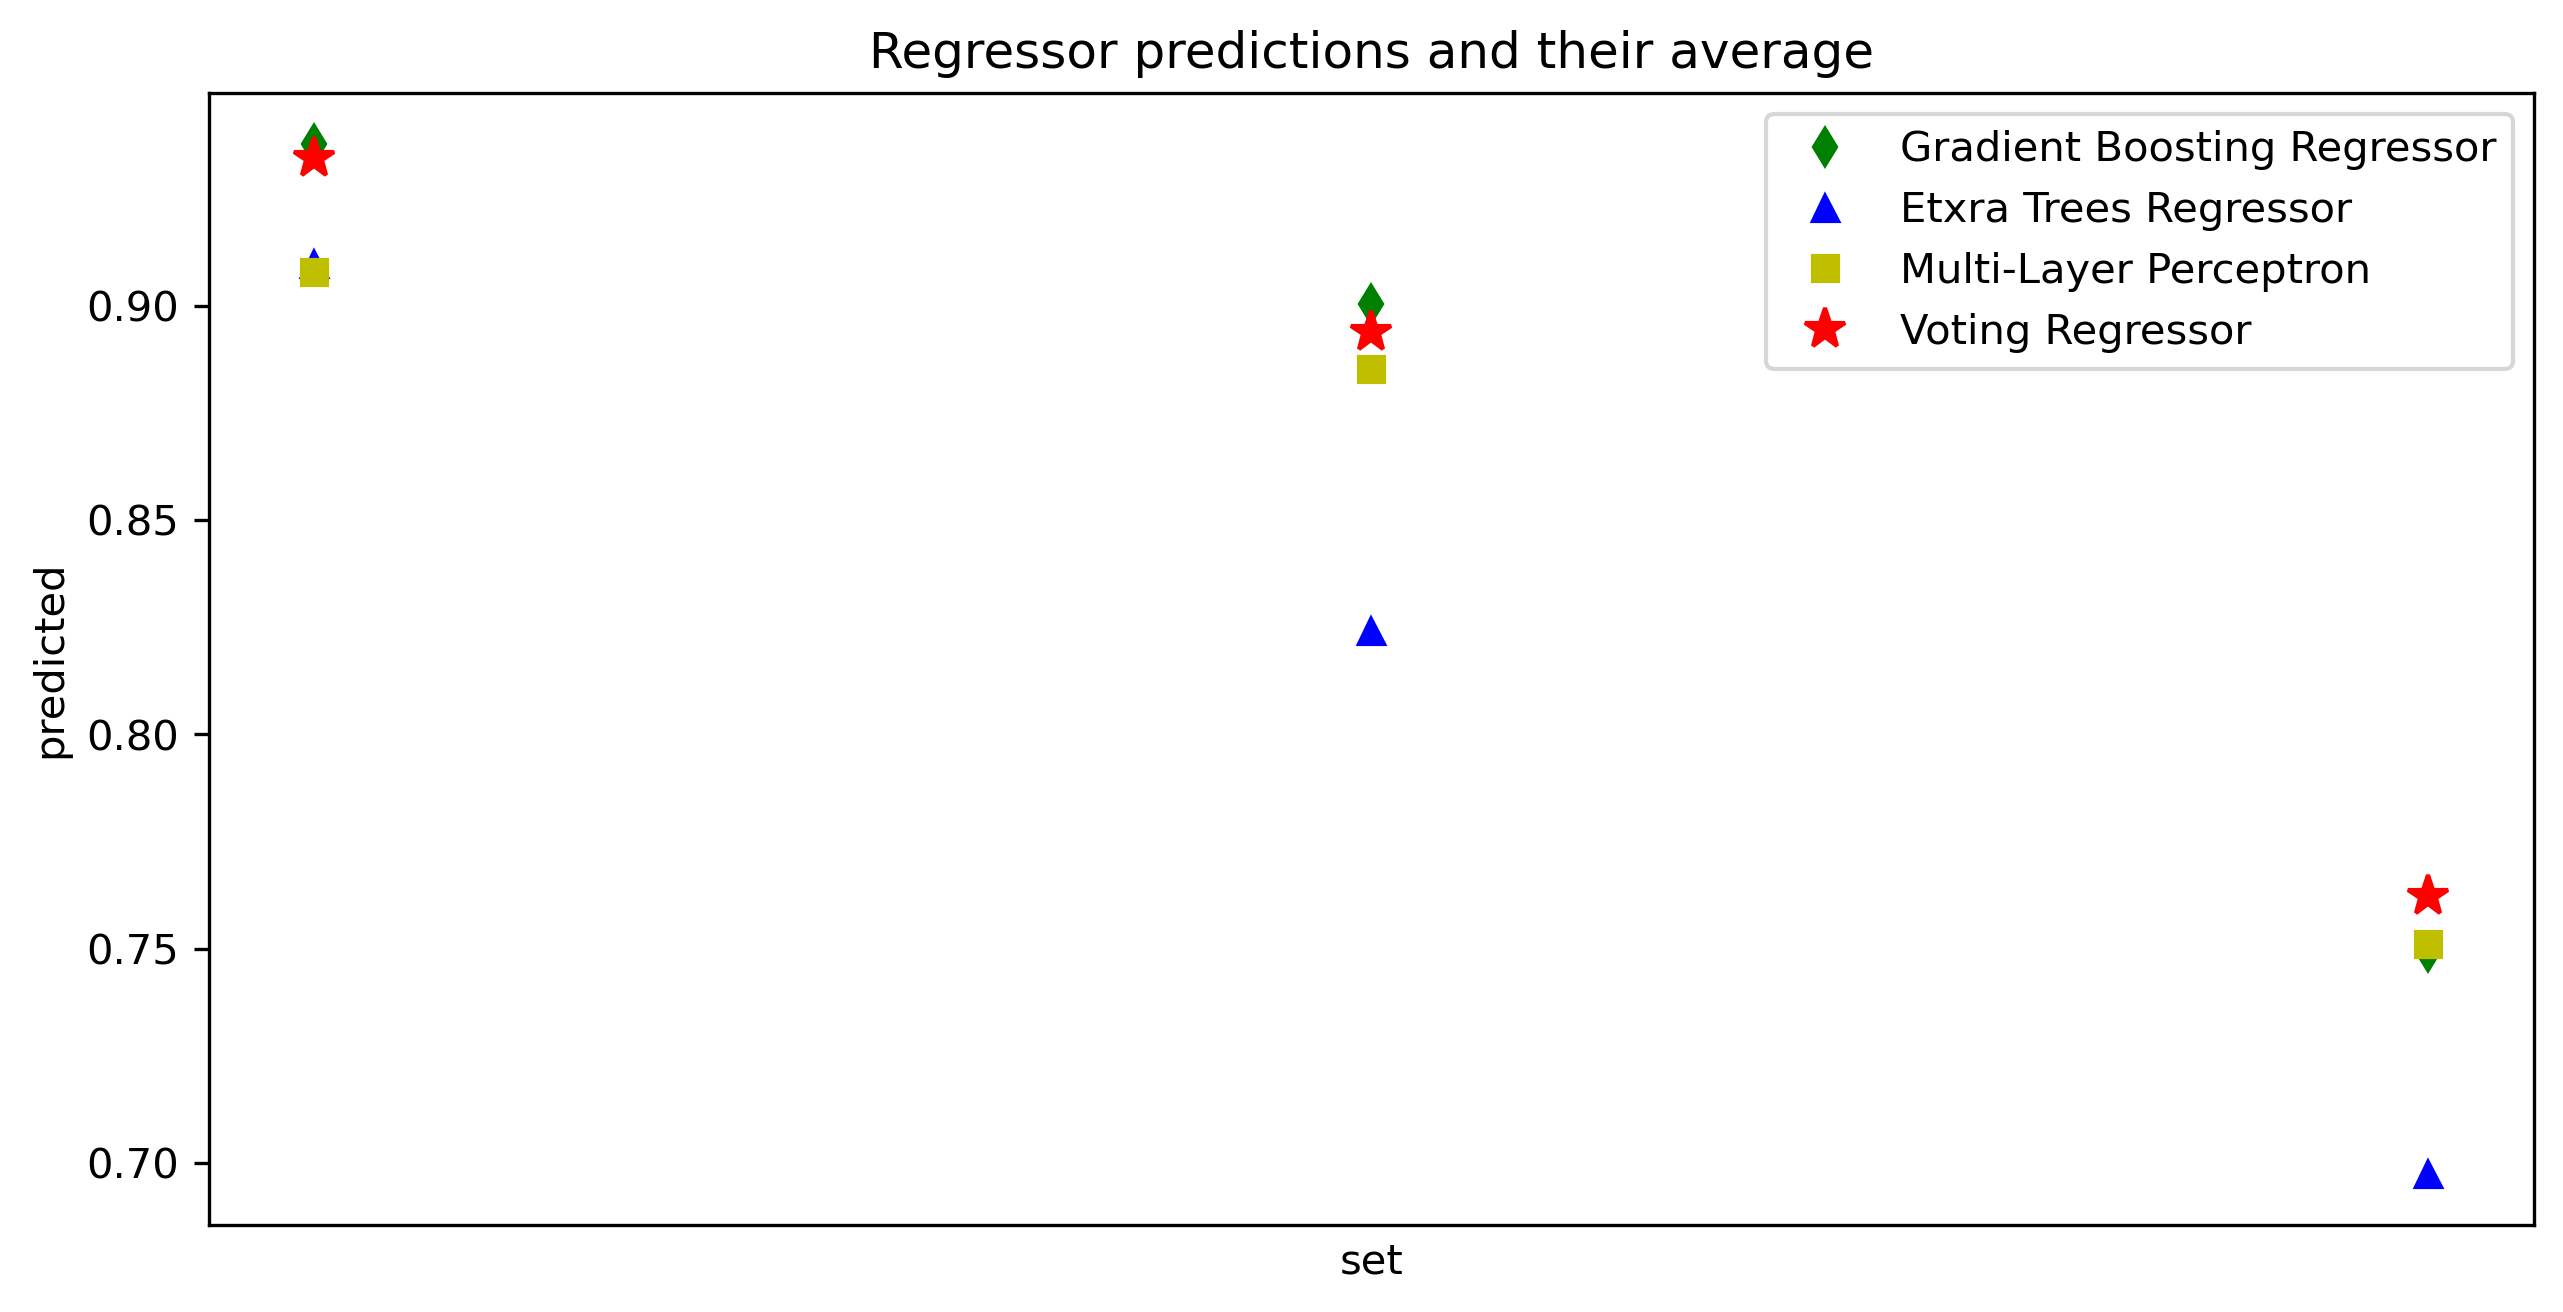

In [ ]:
plt.figure(figsize=(10, 5), dpi=300)
#testSet
plt.plot(GBTLine, 'gd', label='Gradient Boosting Regressor')
plt.plot(ExtTrLine, 'b^', label='Etxra Trees Regressor')
plt.plot(MLPLine, 'ys', label='Multi-Layer Perceptron')
plt.plot(combiLine, 'r*', ms=10, label='Voting Regressor')

plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted')
plt.xlabel('set')
plt.legend(loc="best")
plt.title('Regressor predictions and their average')

plt.show()

Auf basis der Accuracy und dem Mean Squared Error ist der Voting Regressor das beste Modell. Er performed auf den Trainingsdaten etwas schlechter als der Extra Trees Regressor, allerdings wird er besser je unbekannter die Daten sind. Der Voting Regressor scheint also robuster zu sein.

### 7.2. Grafischer Vergleich der Modelle

Der Grafische Vergleich der verschiedenen Modelle ist gut dafür geignet die Lernkurve, Skalierbarkeit und Performance zu verglichen.
Die Idee für den Code zur Grafischen Darstellung basiert auf einen Artikel aus SciKit, welcher [hier](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html) gefunden werden kann.

Durch die Verwendung von Cross Validation kann um die Linien drum herum immer ein Konfidenzintervall gezeichnet werden. Innerhalb dieser Linien bewegen sich die Maximal- und Minimalwerte.

#### 7.2.1. Skalierbarkeit

Als erstes soll die Skalierbarkeit der Modelle verglichen werden. Sie gibt eine Aussage darüber, wie gut das Modell auch auf größeren Datenmengen trainiert werden kann. So zeigt die folgende Grafik auf der Y-Achse die Zeit zum trainieren und auf der X-Achse die anzahl an Trainingssamples.

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

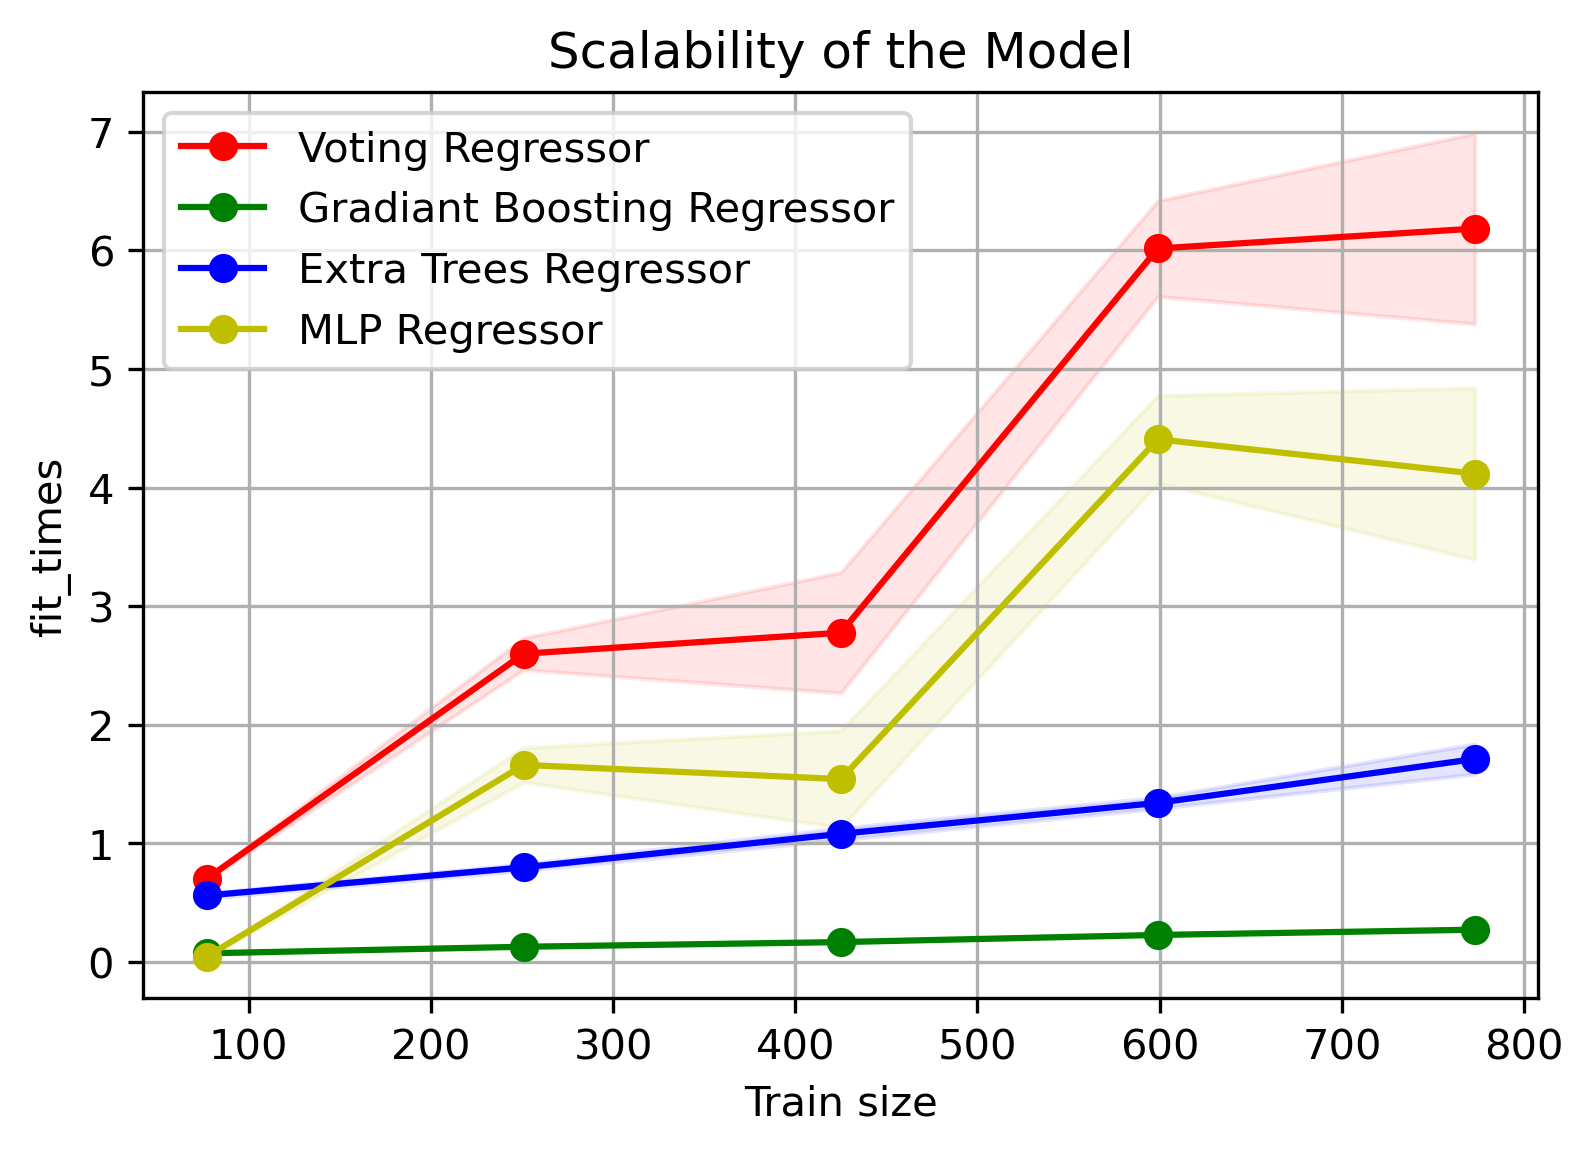

In [ ]:
plt.figure(dpi=300)
# Voting Regressor
estimator = VotingRegressor([('gb', reg1), ('rf', reg2), ('lr', reg3)])
plot_learning_curve(estimator, title, X_train, Y_train, axes=axes[:, 0], ylim=(0, 1.01),
                    n_jobs=6)
train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X_test, Y_test, cv=cv, n_jobs=7,
                       return_times=True)

fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

plt.grid()
plt.plot(train_sizes, fit_times_mean, 'o-', color="r",
                 label="Voting Regressor")
plt.fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1,color="r")


# Gradient Boosting Tree
estimator = GradientBoostingRegressor(alpha= 0.939172792746644,
                                               learning_rate= 0.06954145170602204,
                                               loss= 'ls',
                                               min_samples_leaf= 6,
                                               n_estimators= 166,
                                               random_state= 28,
                                               subsample = 0.9597978557688435)
train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X_test, Y_test, cv=cv, n_jobs=7,
                       return_times=True)

fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

plt.plot(train_sizes, fit_times_mean, 'o-', color="g",
                 label="Gradiant Boosting Regressor")
plt.fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)

# Extra Trees Regressor
estimator = ExtraTreesRegressor(bootstrap=False,criterion="mse",max_features=0.9,min_samples_leaf=4,n_estimators=500)
train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X_test, Y_test, cv=cv, n_jobs=7,
                       return_times=True)

fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

plt.plot(train_sizes, fit_times_mean, 'o-', color="b",
                 label="Extra Trees Regressor")
plt.fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1,color="b")

# MLP Regressor
estimator = MLPRegressor(activation="relu", alpha=0.00001, learning_rate = "constant", learning_rate_init = 0.01, shuffle = True, solver="adam" ,random_state=1, max_iter=5000)
train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X_test, Y_test, cv=cv, n_jobs=7,
                       return_times=True)

fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

plt.plot(train_sizes, fit_times_mean, 'o-', color="y",
                 label="MLP Regressor")
plt.fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1, color="y")


plt.xlabel("Train size")
plt.ylabel("fit_times")
plt.title('Scalability of the Model')
plt.legend(loc="best")

plt.show()

Die Grafik zeigt, dass der Extra Trees Regressor und der Gradient Boosting Tree sehr gut im vergleich zum MLP-Regressor Skalieren. Der Anstieg in der Trainingszeit ist trotz größerer Datenmenge nur gering und nahezu Linear. Anders verhält sich der MLP Regressor. Dieser steigt wesentlich stärker an und je nach Datenaufteilung scheint es auch eine Schwankung zu geben.

Der Voting Regressor ist eine Kombination der anderen Techniken. Denn alle drei Modelle müssen trainiert werden. Daher ist der Wert die Summe der anderen Modelle und die Skalierbarkeit ist hier am schlechtesten.

#### 7.2.2. Performance

Nun soll näher beleuchtet werden, wie siech die Trainingszeit auf die Performance des Modells auswirkt.

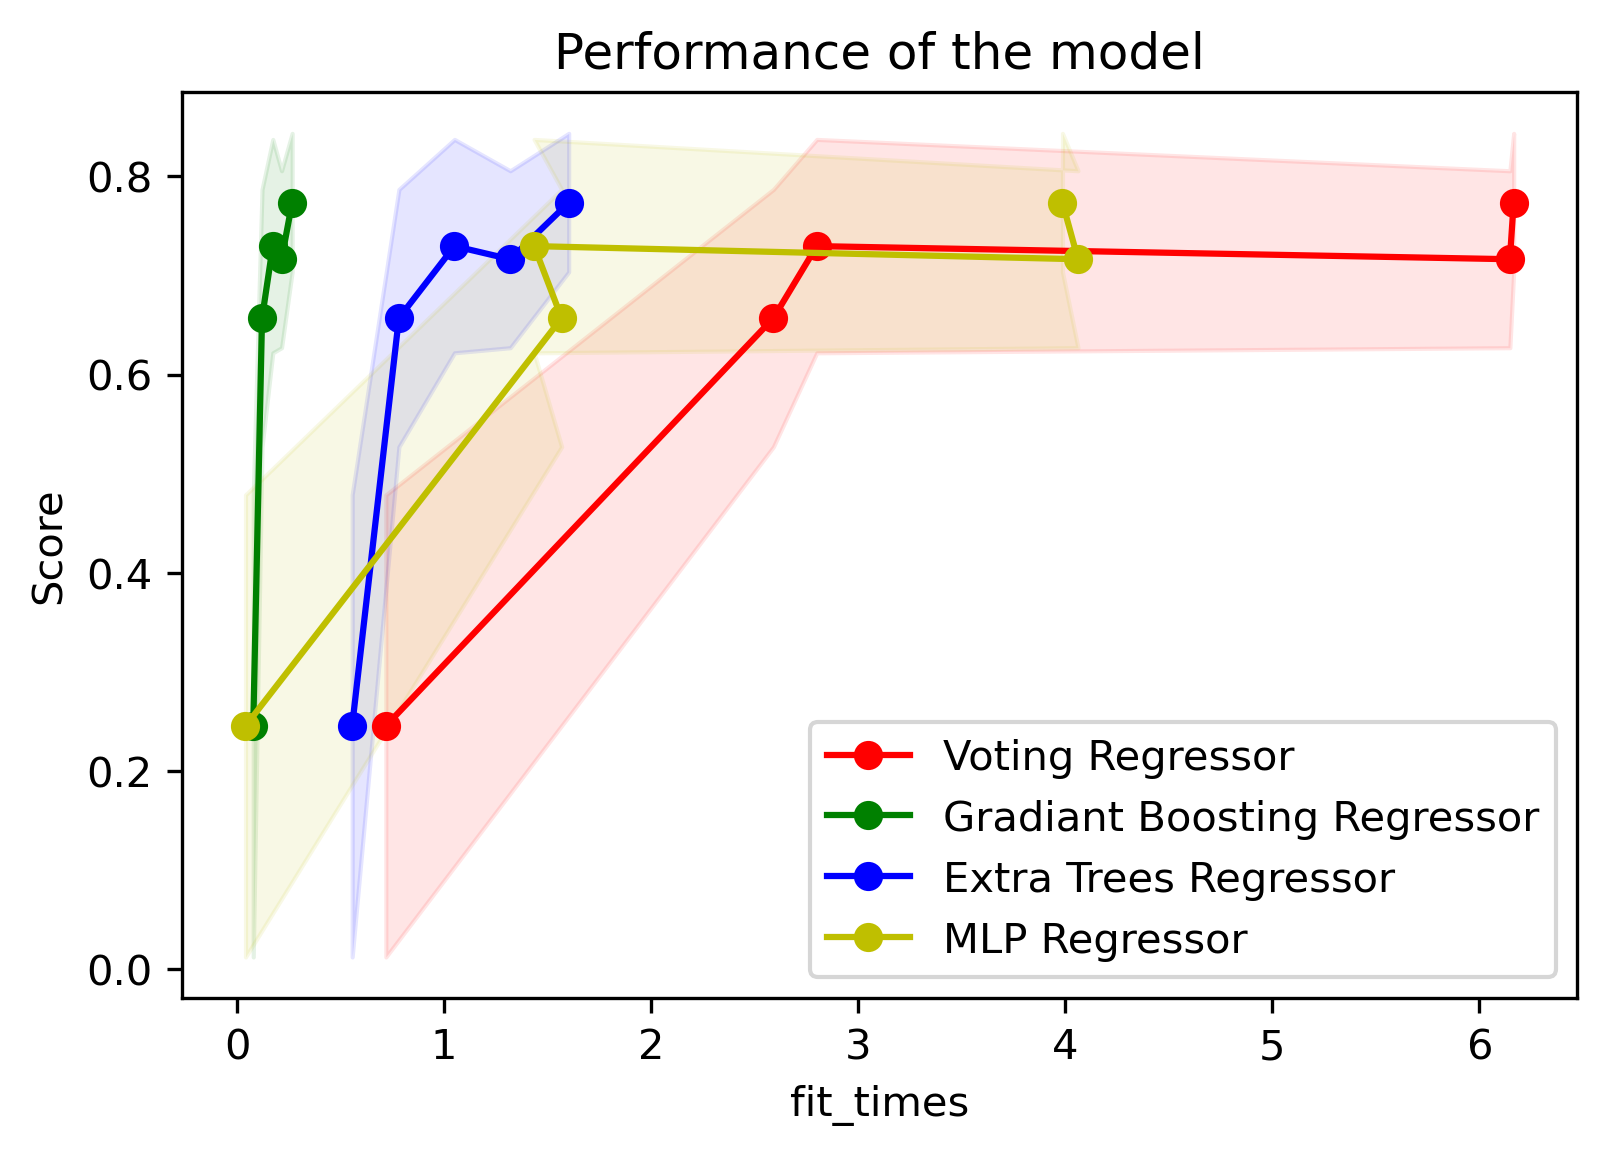

In [ ]:
cv = None
X_test = df_X
Y_test = df_Y
plt.figure(dpi=300)
# Voting Regressor
estimator = VotingRegressor([('gb', reg1), ('rf', reg2), ('lr', reg3)])
plot_learning_curve(estimator, title, X_train, Y_train, axes=axes[:, 0], ylim=(0, 1.01),
                    n_jobs=6)
train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X_test, Y_test, cv=cv, n_jobs=7,
                       return_times=True)

fit_times_mean = np.mean(fit_times, axis=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)


plt.grid()
plt.grid()
plt.plot(fit_times_mean, test_scores_mean, 'o-', color="r",
                 label="Voting Regressor")
plt.fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="r")


# Gradient Boosting Tree
estimator = GradientBoostingRegressor(alpha= 0.939172792746644,
                                               learning_rate= 0.06954145170602204,
                                               loss= 'ls',
                                               min_samples_leaf= 6,
                                               n_estimators= 166,
                                               random_state= 28,
                                               subsample = 0.9597978557688435)
train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X_test, Y_test, cv=cv, n_jobs=7,
                       return_times=True)

fit_times_mean = np.mean(fit_times, axis=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)


plt.grid()
plt.grid()
plt.plot(fit_times_mean, test_scores_mean, 'o-', color="g",
                 label="Gradiant Boosting Regressor")
plt.fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")

# Extra Trees Regressor
estimator = ExtraTreesRegressor(bootstrap=False,criterion="mse",max_features=0.9,min_samples_leaf=4,n_estimators=500)
train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X_test, Y_test, cv=cv, n_jobs=7,
                       return_times=True)

fit_times_mean = np.mean(fit_times, axis=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)


plt.grid()
plt.grid()
plt.plot(fit_times_mean, test_scores_mean, 'o-', color="b",
                 label="Extra Trees Regressor")
plt.fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="b")

# MLP Regressor
estimator = MLPRegressor(activation="relu", alpha=0.00001, learning_rate = "constant", learning_rate_init = 0.01, shuffle = True, solver="adam" ,random_state=1, max_iter=5000)
train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X_test, Y_test, cv=cv, n_jobs=7,
                       return_times=True)

fit_times_mean = np.mean(fit_times, axis=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)


plt.grid()
plt.grid()
plt.plot(fit_times_mean, test_scores_mean, 'o-', color="y",
                 label="MLP Regressor")
plt.fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="y")


plt.xlabel("fit_times")
plt.ylabel("Score")
plt.title('Performance of the model')
plt.legend(loc="best")

plt.show()

Das Ergebnis ist ähnlich wie schon zuvor bei der Skalierbarkeit. Der Extra Trees Regressor und Gradient Boosting Tree brauchen nur sehr wenig Zeit, um relativ gute Ergebnisse zu generieren. Dem gegenüber braucht der MLP Regressor etwas mehr Zeit.

#### 7.2.3. Lernkurve

Zum Schluss wird noch einmal die Lernkurve der verschiedenen Modell verglichen. 

In [ ]:
import time
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt
rng = np.random.RandomState(0)

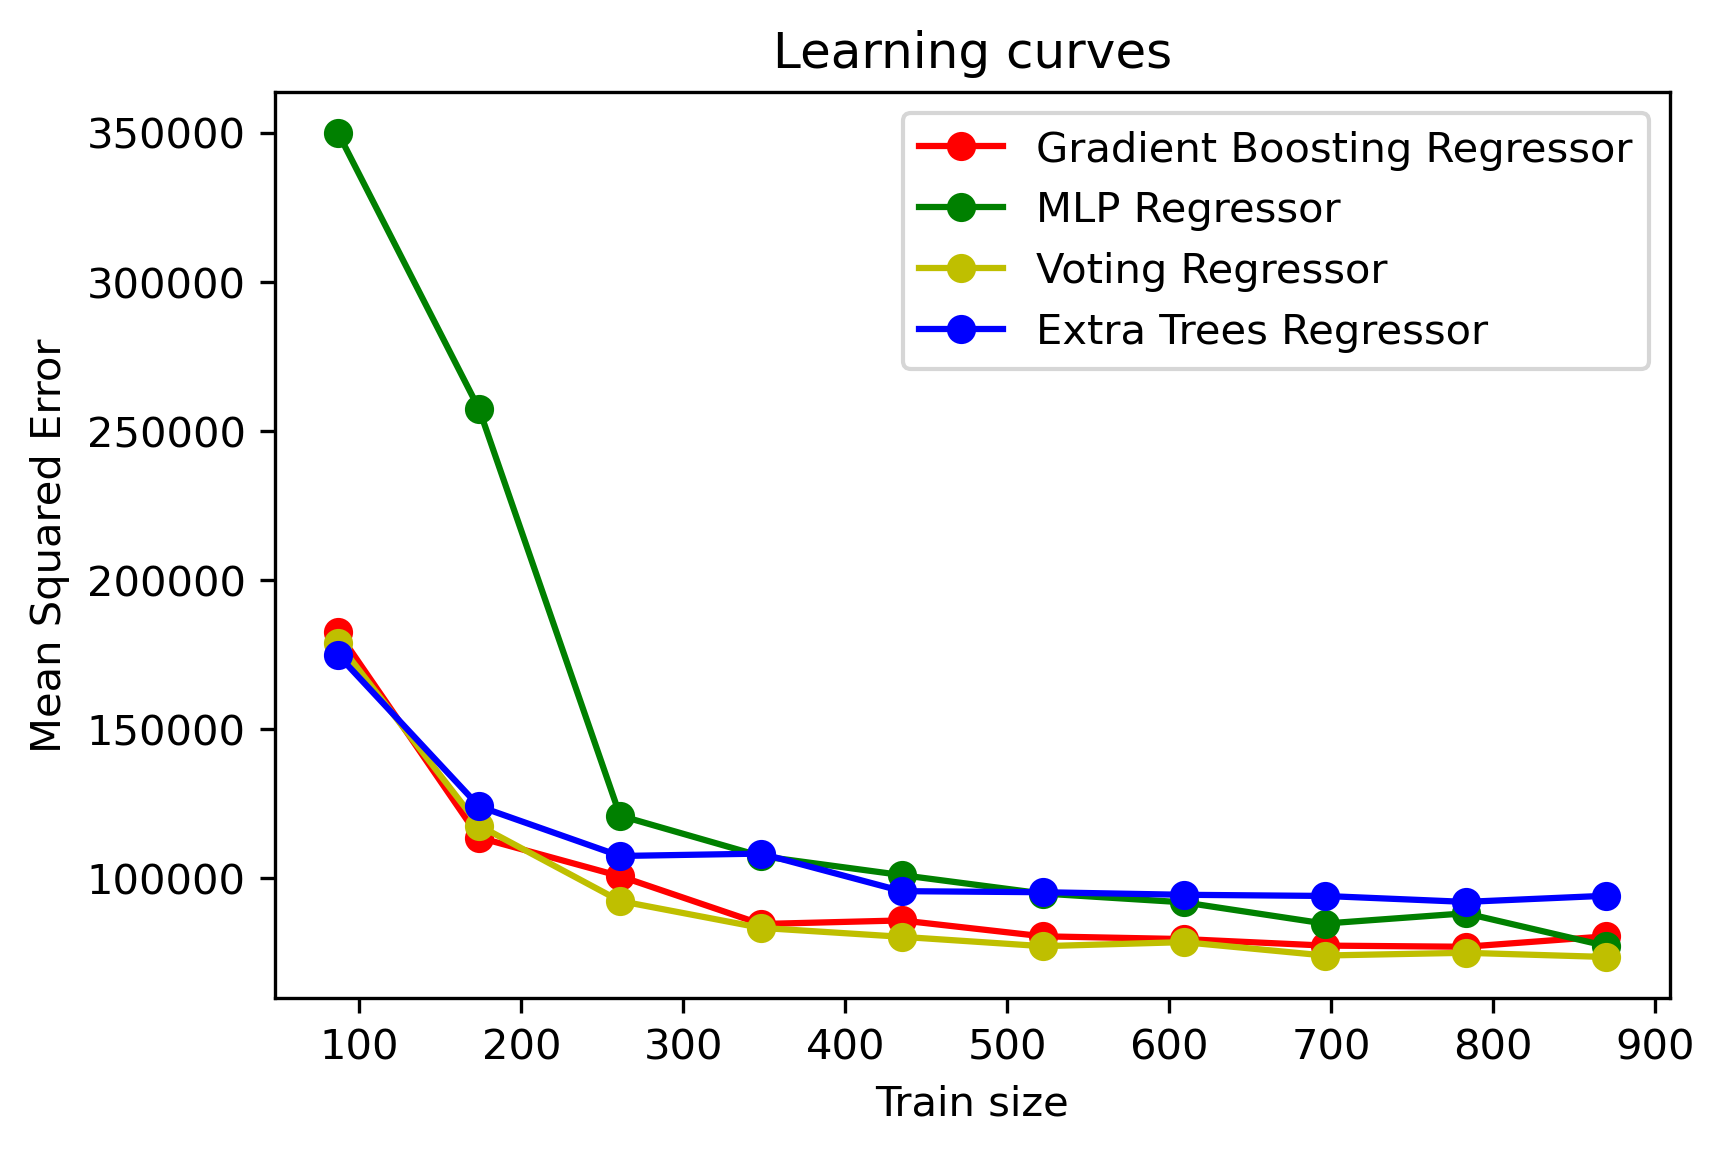

In [ ]:
# Visualize learning curves
plt.figure(dpi=300)
X_train = df_X
Y_train = df_Y

#GBT
gbt = GradientBoostingRegressor(alpha= 0.939172792746644,
                                               learning_rate= 0.06954145170602204,
                                               loss= 'ls',
                                               min_samples_leaf= 6,
                                               n_estimators= 166,
                                               random_state= 28,
                                               subsample = 0.9597978557688435)
train_sizes, train_scores_gbt, test_scores_gbt = \
    learning_curve(gbt, X_train, Y_train, train_sizes=np.linspace(0.1, 1, 10),
                   scoring="neg_mean_squared_error", cv=10)
plt.plot(train_sizes, -test_scores_gbt.mean(1), 'o-', color="r",
         label="Gradient Boosting Regressor")

#MLP
mlp = MLPRegressor(activation="relu", alpha=0.00001, learning_rate = "constant", learning_rate_init = 0.01, shuffle = True, solver="adam" ,random_state=1, max_iter=5000)
train_sizes_abs, train_scores_mlp, test_scores_mlp = \
    learning_curve(mlp, X_train, Y_train, train_sizes=np.linspace(0.1, 1, 10),
                   scoring="neg_mean_squared_error", cv=10)
plt.plot(train_sizes, -test_scores_mlp.mean(1), 'o-', color="g",
         label="MLP Regressor")

#VR
vr = VotingRegressor([('gb', reg1), ('rf', reg2), ('lr', reg3)])
train_sizes_abs, train_scores_vr, test_scores_vr = \
    learning_curve(vr, X_train, Y_train, train_sizes=np.linspace(0.1, 1, 10),
                   scoring="neg_mean_squared_error", cv=10)
plt.plot(train_sizes, -test_scores_vr.mean(1), 'o-', color="y",
         label="Voting Regressor")
#ExTr
et = ExtraTreesRegressor(bootstrap=False,criterion="mse",max_features=0.9,min_samples_leaf=4,n_estimators=500)
train_sizes, train_scores_et, test_scores_et = \
    learning_curve(et, X_train, Y_train, train_sizes=np.linspace(0.1, 1, 10),
                   scoring="neg_mean_squared_error", cv=10)
plt.plot(train_sizes, -test_scores_et.mean(1), 'o-', color="b",
         label="Extra Trees Regressor")


plt.xlabel("Train size")
plt.ylabel("Mean Squared Error")
plt.title('Learning curves')
plt.legend(loc="best")

plt.show()

Es lässt sich erkennen, dass der MLP-Regressor mit einem größeren Mean Squared Error als die anderen Modelle starte. Dies hat auch damit zu tun, dass die Anfangsgewichte nicht optimale Initialwerte haben. Je länger der MLP-Regressor jedoch trainiert, des so besser wird das Modell im Vergleich zu den anderen Modellen.

### 7.3. Verbesserungen am Modell

Das Projekt hat bereits gute Ergebnisse erziehlt. Allerdings kann die Qualität noch verbessert werden. Ein Paar Ideen unsererseits, die zu einem besseren Ergebnis führen würden wären:

> **Normalisierung** - Ein wichtiger Punkt ist die Normalisierung. Es kann in zwei Bereiche unterschieden werden. Der Normalisierung der Daten und speziell in Neuronalen Netzen die Normalisierung der Gewichte, Bias und Layer outputs. Scikit learn hat mit dem MLP-Regressor schon viele Normalisierungstechniken im Neuronalen Netz implementiert, allerdings wäre es sinvoll diese noch einmal Graphisch darzustellen, um eventuelle Fehler zu vermeiden. Auch ein Power Transformation nach Sons Box-Cox oder Yeo-Johnson wäre denkbar.

> **Dimensionsreduktion** - In deisem Projekt gibt es realtiv wenige Daten und Features. Aus diesem Grund wird dieser Punkt erst bei einer Erweiterung des Modells interessant. Trotzdem soll es hier mit aufgeführt werden. Der Gedanke ist, dass mehr Daten zu mehr und komplexeren Kalkulationen führen. Dadurch steigt der Bedarf an Speicher und Laufzeit. Als Resultat wird der Trainingsprozess schwerer. Denn es gibt redundante Daten, welche vom Modell erst einmal aussortiert werden müssen. Im schlimmsten Fall schafft das Modell gar nichts aus den Daten zu lernen. Also liefert die runtergebrochene Dimension eventuell mehr Information und verleit dem Modell eine höhere Robustheit. Folgende Methoden können dies einfach erreichen:

>> **Multicollinarität** - Wenn ein Regressor durch einen anderen Regressor bereits dargestellt wird, kann das schwächere Glied gelöscht werden ohne einen Informationsverlust zu befürchten. 

>> **Partial Dependencies** - Verschiedene Regressoren können sich gegenseitig beinflussen. So könnte z.B. in der Wespensaison der Regen die Anzahl der Wespen beeinflussen, wodurch wieder die Anzahl der Kinder auf einem Spielplatz beinflusst wird. Es ist wichtig solche realtionen zu erkennen, um eventuelle Ausprägungen zu verstehen.

>> **Feature Importance** - Es sollte auch überprüft werden, ob überhaupt eine abhängigkeit vom Regressor und Regressand besteht. ISt dies nicht der Fall kann das Feature entfernt werden.

## 8. Fazit

Für dieses Projekt mussten fast alle Phasen des Data Science Prozesses durchlaufen werden (siehe Abbildung). Einzig der letzte Schritt, der Einsatz und die Wartung des Modells in einer Produktivumgebung waren nicht notwendig. Etwa die Hälfte der Zeit war hierbei für die ersten Schritte (Business-Understanding, Data-Acquisition and Data-Preprocessing) notwendig. 

Die zweite Hälfte der Zeit konnte der Datenanalyse und dem modellieren der verschiedenen Regressoren gewidmet werden. Hierbei wurde schlussendlich ein Ensemble learning-Ansatz gewählt, welcher aus eine Gradient Boosting Tree Regressor, einem extra Tress Regressor und einem Multi-Layer Perceptron besteht. Dies führte zu einer besseren Generaliserung des Modells und somit zu einem besseren Score auf dem Validierungsdatenset.

Die Versuche mit verschiedenen Hidden-Layer Strukturen beim neuronalen Netz zeigten außerdem, dass hierbei ein einfaches Netzt (1-Layer) mindestens genau so gut, in den meisten Fällen sogar deutlich besser, performte, als ein komplexes neuronales Netz mit vielen Layern. Es zeigte sich also, das Modelle so einfach wie möglich und nur so komplex wie notwendig gehalten werden sollten.

Das finale Modell erreichte einen Score (1-R²) von 0.94 auf den Testdaten und 0.9 auf den Validierungsdaten. Die graphische Darstellung der Metriken zeigt, dass das Modell wesentlich robuster als die anderen Modelle gegenüber unbekannten Daten ist, bei einem fast identischen Score auf dem Trainings und Testset.

Das Projekt führte insgesammt zu einem hohen Lernerfolg un­se­rer­seits. Es konnten die meisten der notwendingen Schritte des Data Science Prozesses in der Praxis durchlaufen und erprobt werden. Das hierbei enstandene Modell übertraf unsere Erwartungen deutlich und liefert sehr solide Ergebnisse für die Vorhersage von Mietpreisen in Hamburg.


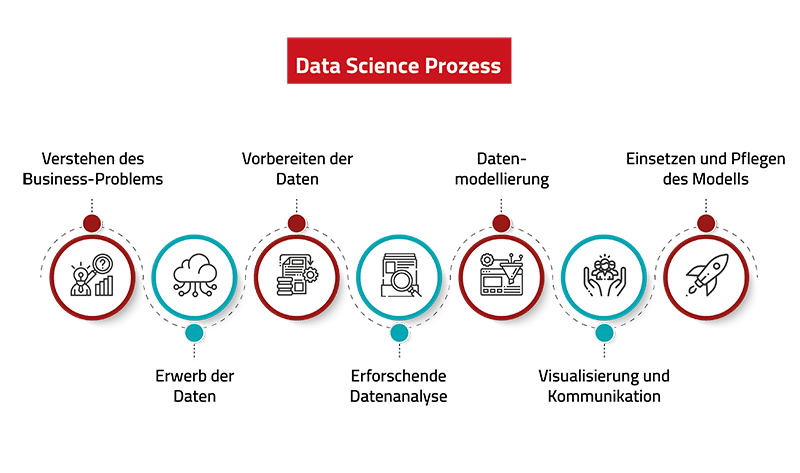